In [45]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
import math

from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn import tree

In [46]:
# Helper functions
def human_format(num):
  """Convert a number to a human readable version, e.g. 10M for 10,000,000."""
  if num == 0:
    return '0'
  letters = ["", "K", "M", "B", "T"]
  scale = math.floor(round(math.log(abs(num), 10)) / 3)
  # Convert to string: truncate to scale, remove trailing zeros and decimal points
  num = float('{:.3g}'.format(num)) / 10**(3*scale)
  num = str(num).rstrip('0').rstrip('.')
  # Append scale letter
  num += letters[scale]
  return num

def mpl_human_format(x, pos):
  if pos is not None:
    return human_format(x)

def make_axes_human_readable(ax, axis="y"):
  if axis.lower() == 'x':
    axisvar = ax.xaxis
  elif axis.lower() == 'y':
    axisvar = ax.yaxis
  else:
    raise("Must specify axis as either 'x' or 'y'")

  axisvar.set_major_formatter(matplotlib.ticker.FuncFormatter(mpl_human_format))
  return ax

In [47]:
cluster_1_train_df = pd.concat([pd.read_parquet('dataset/cluster_1/training.parquet'), pd.read_parquet('dataset/cluster_1/validation.parquet')], axis=1)
cluster_1_train_df.columns = pd.to_datetime(cluster_1_train_df.columns)

cluster_1_val_df = pd.read_parquet('dataset/cluster_1/test.parquet')
cluster_1_val_df.columns = pd.to_datetime(cluster_1_val_df.columns)

cluster_2_train_df = pd.concat([pd.read_parquet('dataset/cluster_2/training.parquet'), pd.read_parquet('dataset/cluster_2/validation.parquet')], axis=1)
cluster_2_train_df.columns = pd.to_datetime(cluster_2_train_df.columns)

cluster_2_val_df = pd.read_parquet('dataset/cluster_2/test.parquet')
cluster_2_val_df.columns = pd.to_datetime(cluster_2_val_df.columns)

cluster_3_train_df = pd.concat([pd.read_parquet('dataset/cluster_3/training.parquet'), pd.read_parquet('dataset/cluster_3/validation.parquet')], axis=1)
cluster_3_train_df.columns = pd.to_datetime(cluster_3_train_df.columns)

cluster_3_val_df = pd.read_parquet('dataset/cluster_3/test.parquet')
cluster_3_val_df.columns = pd.to_datetime(cluster_3_val_df.columns)

cluster_4_train_df = pd.concat([pd.read_parquet('dataset/cluster_4/training.parquet'), pd.read_parquet('dataset/cluster_4/validation.parquet')], axis=1)
cluster_4_train_df.columns = pd.to_datetime(cluster_4_train_df.columns)

cluster_4_val_df = pd.read_parquet('dataset/cluster_4/test.parquet')
cluster_4_val_df.columns = pd.to_datetime(cluster_4_val_df.columns)

temperature_df = pd.read_parquet('dataset/temperature/temperature.parquet')

weather_df = pd.read_parquet('dataset/weather/weather.parquet')
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])
weather_df = weather_df.set_index('datetime')
temp_cols = [
    'tempmax',
    'tempmin',
    'temp',
    'feelslikemax',
    'feelslikemin',
    'feelslike',
]
# Convert to degrees Celsius
weather_df[temp_cols] = weather_df[temp_cols].apply(lambda t: (t - 32) * 5 / 9).round(2)

public_holidays_df = pd.read_parquet('dataset/public_holidays/public_holidays.parquet')
electricity_price_df = pd.read_parquet('dataset/electricity_price/electricity_price.parquet')

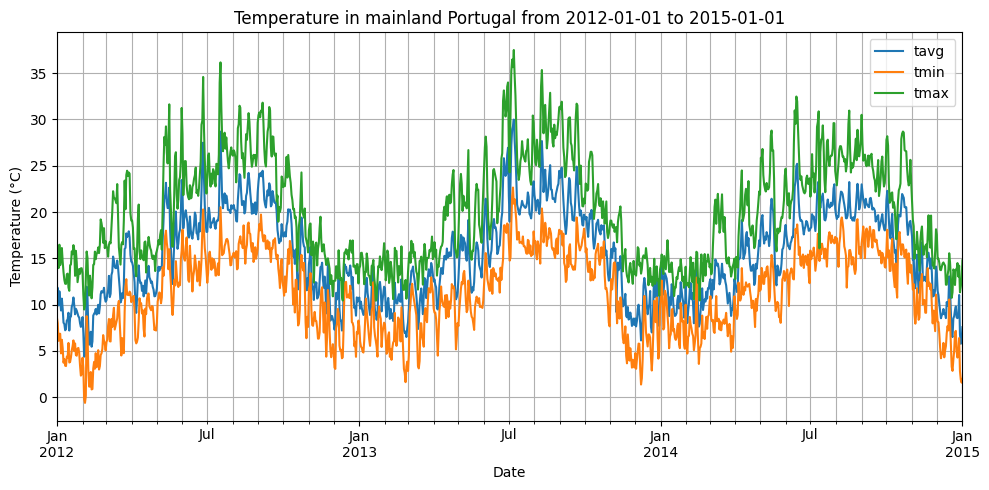

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

temperature_df.T.plot(ax=ax)

ax.set_title('Temperature in mainland Portugal from 2012-01-01 to 2015-01-01')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')
ax.grid(True, which='both')

plt.tight_layout()
plt.show()

In [49]:
weather_df.head()

name  tempmax  tempmin   temp  feelslikemax  feelslikemin  \
datetime                                                                    
2012-01-01  portugal    15.00    10.33  13.00         15.00         10.33   
2012-01-02  portugal    16.67    10.17  13.22         16.67         10.17   
2012-01-03  portugal    15.06     7.00  10.94         15.06          7.00   
2012-01-04  portugal    18.06     9.17  13.56         18.06          9.17   
2012-01-05  portugal    17.22    10.78  13.22         17.22         10.78   

            feelslike   dew  humidity  precip  ...  solarenergy  uvindex  \
datetime                                       ...                         
2012-01-01      13.00  49.6      81.4   0.000  ...          6.8        3   
2012-01-02      13.22  48.7      78.6   0.111  ...          7.9        4   
2012-01-03      10.94  45.2      79.1   0.000  ...          9.3        4   
2012-01-04      13.56  47.4      72.6   0.000  ...         10.8        5   
2012-01-05      13.22  49.8      80.7   0.000  ...         10.5        5   

           severerisk             sunrise              sunset  moonphase  \
datetime                                                                   
2012-01-01       None 2012-01-01 07:54:46 2012-01-01 17:25:13       0.25   
2012-01-02       None 2012-01-02 07:54:54 2012-01-02 17:26:02       0.28   
2012-01-03       None 2012-01-03 07:55:01 2012-01-03 17:26:52       0.31   
2012-01-04       None 2012-01-04 07:55:05 2012-01-04 17:27:43       0.35   
2012-01-05       None 2012-01-05 07:55:07 2012-01-05 17:28:36       0.38   

                        conditions  \
datetime                             
2012-01-01        Partially cloudy   
2012-01-02  Rain, Partially cloudy   
2012-01-03        Partially cloudy   
2012-01-04                   Clear   
2012-01-05        Partially cloudy   

                                                  description  \
datetime                                                        
2012-01-01                  Partly cloudy throughout the day.   
2012-01-02  Partly cloudy throughout the day with morning ...   
2012-01-03                  Partly cloudy throughout the day.   
2012-01-04               Clear conditions throughout the day.   
2012-01-05                  Partly cloudy throughout the day.   

                         icon  \
datetime                        
2012-01-01  partly-cloudy-day   
2012-01-02               rain   
2012-01-03  partly-cloudy-day   
2012-01-04          clear-day   
2012-01-05  partly-cloudy-day   

                                                     stations  
datetime                                                       
2012-01-01  08535099999,08534099999,08531099999,LPMT,08536...  
2012-01-02  08535099999,08532099999,08534099999,LPMT,08536...  
2012-01-03  08535099999,08532099999,08534099999,0853109999...  
2012-01-04  08535099999,08532099999,08534099999,LPMT,08536...  
2012-01-05  08535099999,08532099999,08534099999,0853109999...  

[5 rows x 32 columns]

In [50]:
weather_df.columns

Index(['name', 'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin',
       'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover',
       'preciptype', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
       'solarenergy', 'uvindex', 'severerisk', 'sunrise', 'sunset',
       'moonphase', 'conditions', 'description', 'icon', 'stations'],
      dtype='object')

In [51]:
avg_temp = temperature_df.T['tavg']
min_temp = temperature_df.T['tmin']
max_temp = temperature_df.T['tmax']

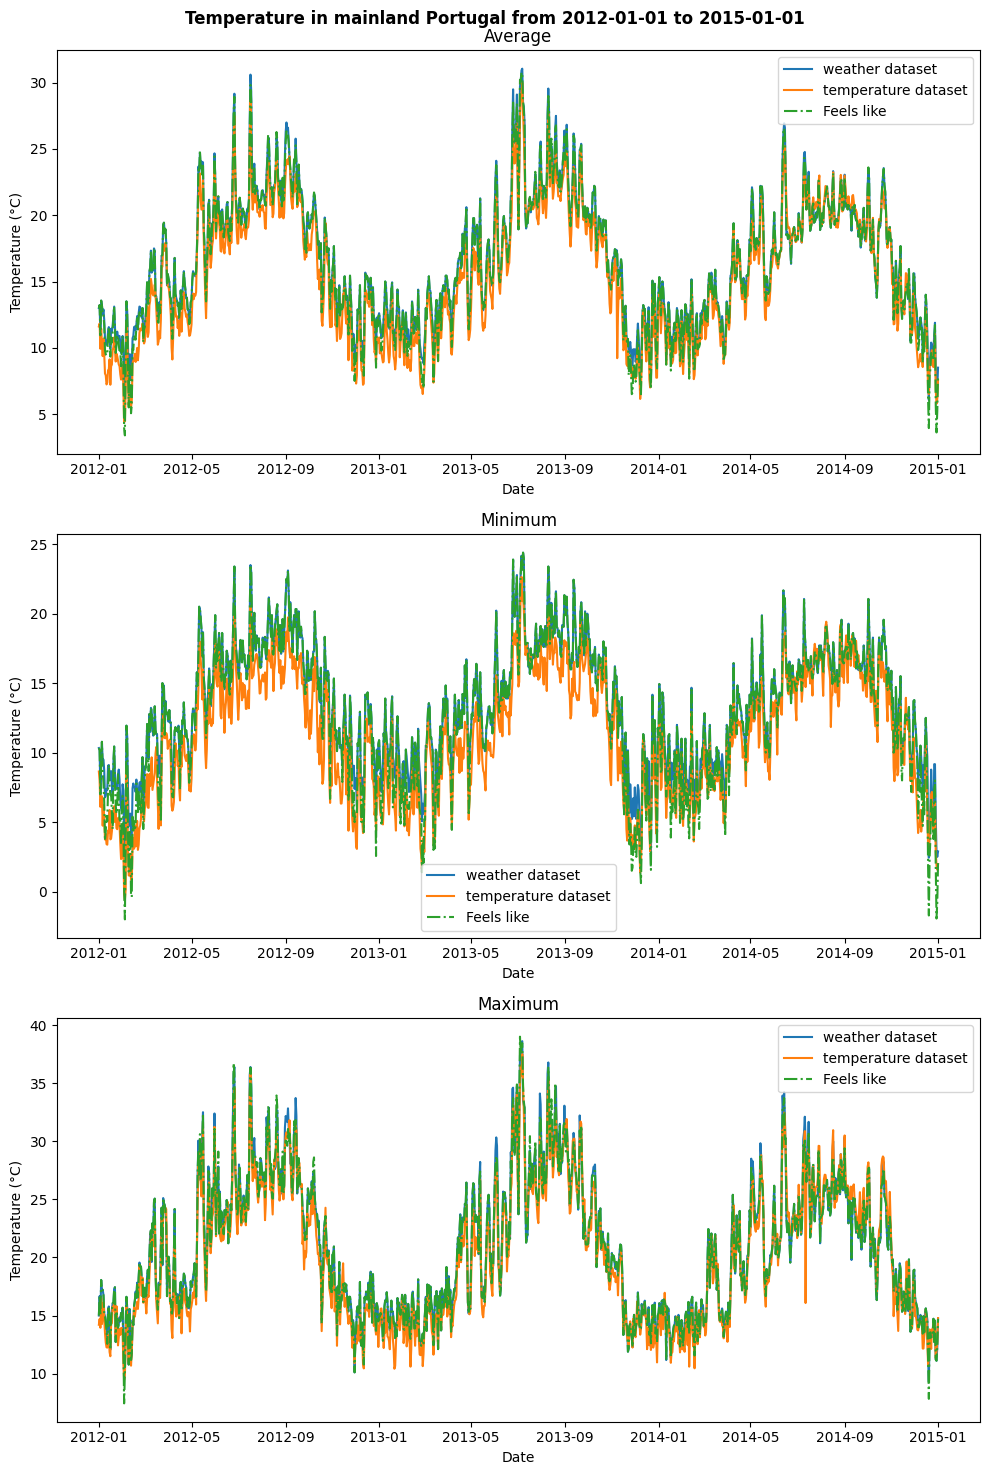

In [52]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10,15))

fig.suptitle('Temperature in mainland Portugal from 2012-01-01 to 2015-01-01', fontweight='bold')

axs[0].plot(weather_df['temp'], label='weather dataset')
axs[0].plot(avg_temp, label='temperature dataset')
axs[0].plot(weather_df['feelslike'], label='Feels like', linestyle='-.')

axs[0].set_title('Average')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Temperature (°C)')
axs[0].legend()

axs[1].plot(weather_df['tempmin'], label='weather dataset')
axs[1].plot(min_temp, label='temperature dataset')
axs[1].plot(weather_df['feelslikemin'], label='Feels like', linestyle='-.')

axs[1].set_title('Minimum')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Temperature (°C)')
axs[1].legend()

axs[2].plot(weather_df['tempmax'], label='weather dataset')
axs[2].plot(max_temp, label='temperature dataset')
axs[2].plot(weather_df['feelslikemax'], label='Feels like', linestyle='-.')

axs[2].set_title('Maximum')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Temperature (°C)')
axs[2].legend()

plt.tight_layout()
plt.show()

In [53]:
# Extract features
avg_temp = temperature_df.T['tavg']
min_temp = temperature_df.T['tmin']
max_temp = temperature_df.T['tmax']

cooling_degree_days = ((max_temp + min_temp) / 2).apply(lambda t: max(0, t - 18))
cooling_degree_days.name = 'cooling_degree_days'

heating_degree_days = ((max_temp + min_temp) / 2).apply(lambda t: max(0, 18 - t))
heating_degree_days.name = 'heating_degree_days'

feelslike_temp = weather_df['feelslike']
feelslikemax_temp = weather_df['feelslikemax']
feelslikemin_temp = weather_df['feelslikemin']

dew = weather_df['dew']
humidity = weather_df['humidity']
precip = weather_df['precip']
precip_prob = weather_df['precipprob'] / 100

solar_radidation = weather_df['solarradiation']
solar_energy = weather_df['solarenergy']
uv_index = weather_df['uvindex']

sunrise_minutes_since_midnight = (weather_df['sunrise'].dt.hour * 60) + weather_df['sunrise'].dt.minute
sunset_minutes_since_midnight = (weather_df['sunset'].dt.hour * 60) + weather_df['sunset'].dt.minute
sunlight_length_hours = ((sunset_minutes_since_midnight - sunrise_minutes_since_midnight) / 60).round(0)
sunlight_length_hours.name = 'sunlight_length_hours'

date_range = pd.date_range(start='2012-01-01', end='2015-01-01', freq='D')
df_all_dates = pd.DataFrame({'Date': date_range})
df_all_dates['Date'] = pd.to_datetime(df_all_dates['Date'])
df_all_dates = df_all_dates.merge(public_holidays_df, on="Date", how="left")
df_all_dates = df_all_dates.set_index('Date')
is_holiday = df_all_dates['Name'].notna().astype(int)
is_holiday.name = 'is_holiday'
holiday_categorical_df = pd.get_dummies(df_all_dates, columns=['Name'], prefix='Holiday').astype(int)

electricity_price = electricity_price_df

day_of_week = pd.Series(index=date_range, data=date_range.dayofweek).replace({
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday',
})
day_of_week_categorical_df = pd.get_dummies(day_of_week).astype(int)

is_weekend = day_of_week.apply(lambda d: d in {'Saturday', 'Sunday'}).astype(int)
is_weekend.name = 'is_weekend'

In [54]:
avg_temp.index.name = 'date'
min_temp.index.name = 'date'
max_temp.index.name = 'date'

heating_degree_days.index.name = 'date'
cooling_degree_days.index.name = 'date'

feelslike_temp.index.name = 'date'
feelslikemin_temp.index.name = 'date'
feelslikemax_temp.index.name = 'date'

dew.index.name = 'date'
humidity.index.name = 'date'
precip.index.name = 'date'
precip_prob.index.name = 'date'

solar_radidation.index.name = 'date'
solar_energy.index.name = 'date'
uv_index.index.name = 'date'

sunrise_minutes_since_midnight.index.name = 'date'
sunset_minutes_since_midnight.index.name = 'date'
sunlight_length_hours.index.name = 'date'

is_holiday.index.name = 'date'
holiday_categorical_df.index.name = 'date'

electricity_price.index.name = 'date'

day_of_week_categorical_df.index.name = 'date'

is_weekend.index.name = 'date'

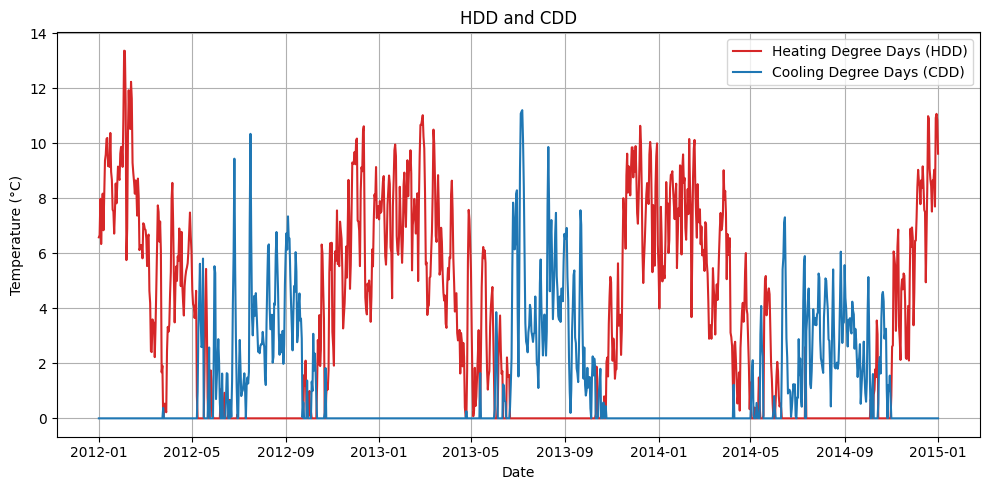

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

ax.plot(heating_degree_days, color='tab:red', label='Heating Degree Days (HDD)')
ax.plot(cooling_degree_days, color='tab:blue', label='Cooling Degree Days (CDD)')

ax.set_title('HDD and CDD')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')
ax.legend()
ax.grid(True, which='both')

plt.tight_layout()
plt.show()

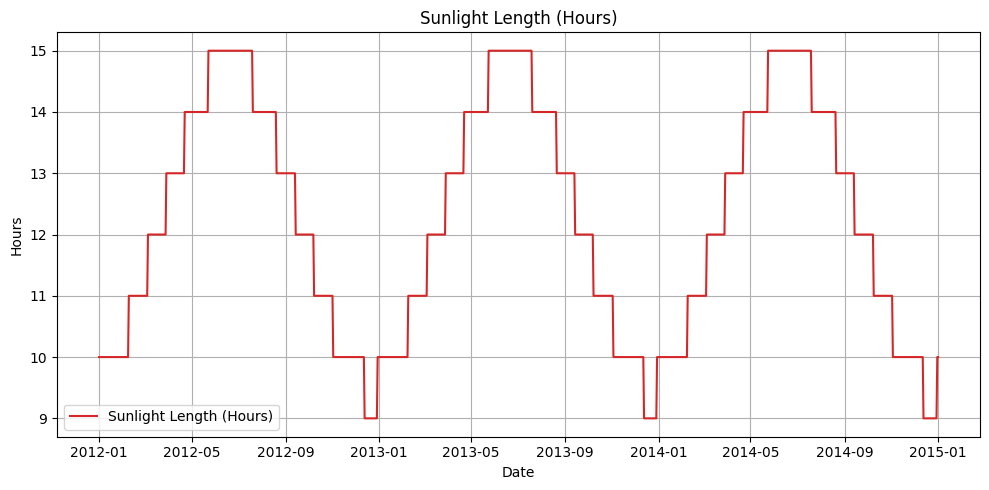

In [84]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

ax.plot(sunlight_length_hours, color='tab:red', label='Sunlight Length (Hours)')

ax.set_title('Sunlight Length (Hours)')
ax.set_xlabel('Date')
ax.set_ylabel('Hours')
ax.legend()
ax.grid(True, which='both')

plt.tight_layout()
plt.show()

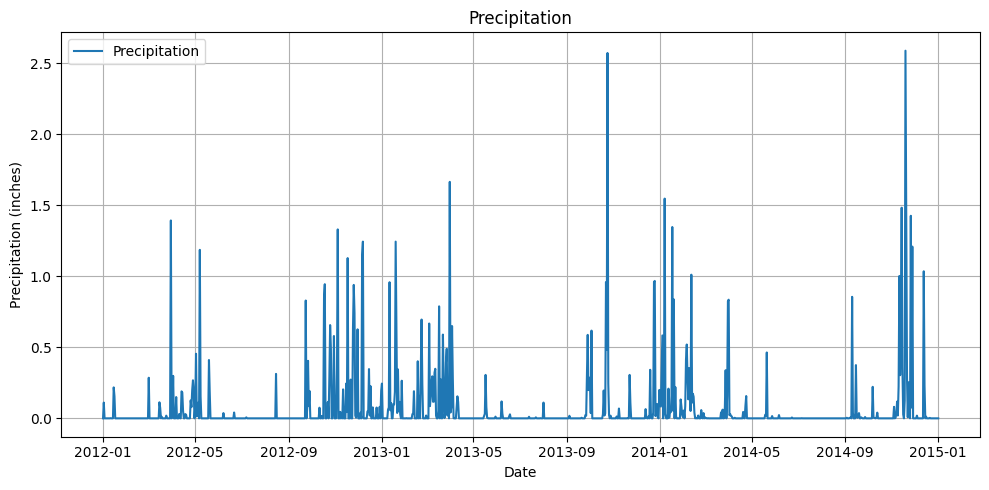

In [96]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

ax.plot(precip, color='tab:blue', label='Precipitation')

ax.set_title('Precipitation')
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (inches)')
ax.legend()
ax.grid(True, which='both')

plt.tight_layout()
plt.show()

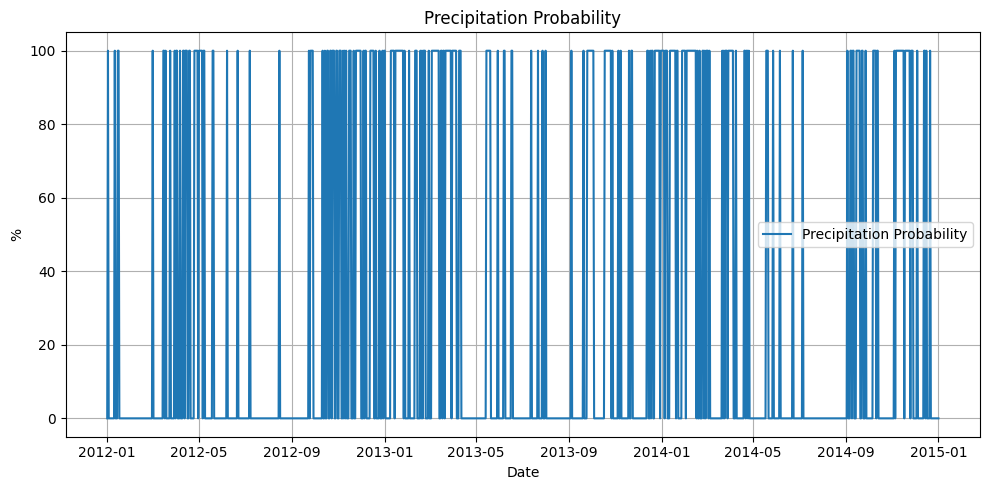

In [97]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

ax.plot(precip_prob * 100, color='tab:blue', label='Precipitation Probability')

ax.set_title('Precipitation Probability')
ax.set_xlabel('Date')
ax.set_ylabel('%')
ax.legend()
ax.grid(True, which='both')

plt.tight_layout()
plt.show()

In [98]:
precip_prob.unique()

array([0., 1.])

In [56]:
cluster_1_train_total = cluster_1_train_df.sum(axis=0)
cluster_1_train_total.index.name = 'date'
cluster_1_train_total.name = 'cluster1_electricity_usage'

cluster_1_val_total = cluster_1_val_df.sum(axis=0)
cluster_1_val_total.index.name = 'date'
cluster_1_val_total.name = 'cluster1_electricity_usage'

cluster_2_train_total = cluster_2_train_df.sum(axis=0)
cluster_2_train_total.index.name = 'date'
cluster_2_train_total.name = 'cluster2_electricity_usage'

cluster_2_val_total = cluster_2_val_df.sum(axis=0)
cluster_2_val_total.index.name = 'date'
cluster_2_val_total.name = 'cluster2_electricity_usage'

cluster_3_train_total = cluster_3_train_df.sum(axis=0)
cluster_3_train_total.index.name = 'date'
cluster_3_train_total.name = 'cluster3_electricity_usage'

cluster_3_val_total = cluster_3_val_df.sum(axis=0)
cluster_3_val_total.index.name = 'date'
cluster_3_val_total.name = 'cluster3_electricity_usage'

cluster_4_train_total = cluster_4_train_df.sum(axis=0)
cluster_4_train_total.index.name = 'date'
cluster_4_train_total.name = 'cluster4_electricity_usage'

cluster_4_val_total = cluster_4_val_df.sum(axis=0)
cluster_4_val_total.index.name = 'date'
cluster_4_val_total.name = 'cluster4_electricity_usage'

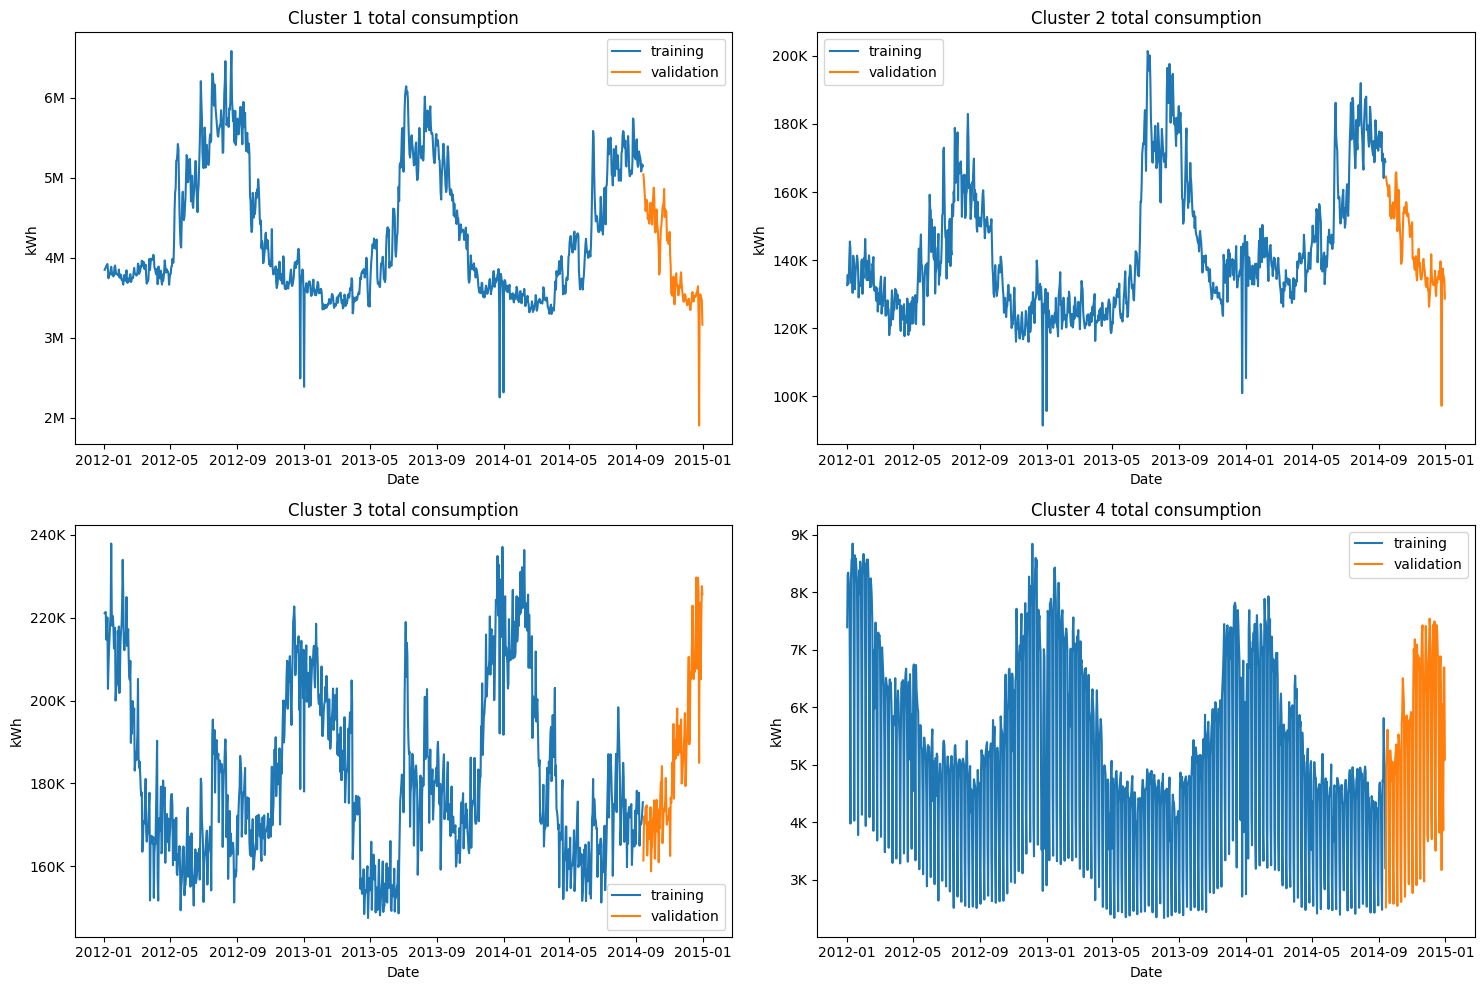

In [57]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

axs[0,0].plot(cluster_1_train_total, label='training')
axs[0,0].plot(cluster_1_val_total, label='validation')

make_axes_human_readable(axs[0,0])
axs[0,0].set_title('Cluster 1 total consumption')
axs[0,0].set_xlabel('Date')
axs[0,0].set_ylabel('kWh')
axs[0,0].legend()

axs[0,1].plot(cluster_2_train_total, label='training')
axs[0,1].plot(cluster_2_val_total, label='validation')

make_axes_human_readable(axs[0,1])
axs[0,1].set_title('Cluster 2 total consumption')
axs[0,1].set_xlabel('Date')
axs[0,1].set_ylabel('kWh')
axs[0,1].legend()

axs[1,0].plot(cluster_3_train_total, label='training')
axs[1,0].plot(cluster_3_val_total, label='validation')

make_axes_human_readable(axs[1,0])
axs[1,0].set_title('Cluster 3 total consumption')
axs[1,0].set_xlabel('Date')
axs[1,0].set_ylabel('kWh')
axs[1,0].legend()

axs[1,1].plot(cluster_4_train_total, label='training')
axs[1,1].plot(cluster_4_val_total, label='validation')

make_axes_human_readable(axs[1,1])
axs[1,1].set_title('Cluster 4 total consumption')
axs[1,1].set_xlabel('Date')
axs[1,1].set_ylabel('kWh')
axs[1,1].legend()

plt.tight_layout()
plt.show()

In [58]:
explanatory_variable_series = [
    avg_temp,
    min_temp,
    max_temp,
    feelslike_temp,
    feelslikemin_temp,
    feelslikemax_temp,
    heating_degree_days,
    cooling_degree_days,
    dew,
    humidity,
    precip,
    precip_prob,
    solar_radidation,
    solar_energy,
    uv_index,
    sunrise_minutes_since_midnight,
    sunset_minutes_since_midnight,
    sunlight_length_hours,
    electricity_price,
    is_holiday,
    holiday_categorical_df,
    day_of_week_categorical_df,
    is_weekend,
]

explanatory_variables_df = pd.concat(explanatory_variable_series, join='inner', axis=1)
explanatory_variables_df.head()

tavg      tmin       tmax  feelslike  feelslikemin  \
date                                                                  
2012-01-01  11.610813  8.636912  14.205970      13.00         10.33   
2012-01-02  11.826729  7.981635  14.698529      13.22         10.17   
2012-01-03   9.923062  6.096744  13.947590      10.94          7.00   
2012-01-04  11.448423  6.855606  16.473857      13.56          9.17   
2012-01-05  10.452590  6.860068  14.264390      13.22         10.78   

            feelslikemax  heating_degree_days  cooling_degree_days   dew  \
date                                                                       
2012-01-01         15.00             6.578559                  0.0  49.6   
2012-01-02         16.67             6.659918                  0.0  48.7   
2012-01-03         15.06             7.977833                  0.0  45.2   
2012-01-04         18.06             6.335269                  0.0  47.4   
2012-01-05         17.22             7.437771                  0.0  49.8   

            humidity  ...  Holiday_Republic Implantation  \
date                  ...                                  
2012-01-01      81.4  ...                              0   
2012-01-02      78.6  ...                              0   
2012-01-03      79.1  ...                              0   
2012-01-04      72.6  ...                              0   
2012-01-05      80.7  ...                              0   

            Holiday_Restoration of Independence  Friday  Monday  Saturday  \
date                                                                        
2012-01-01                                    0       0       0         0   
2012-01-02                                    0       0       1         0   
2012-01-03                                    0       0       0         0   
2012-01-04                                    0       0       0         0   
2012-01-05                                    0       0       0         0   

            Sunday  Thursday  Tuesday  Wednesday  is_weekend  
date                                                          
2012-01-01       1         0        0          0           1  
2012-01-02       0         0        0          0           0  
2012-01-03       0         0        1          0           0  
2012-01-04       0         0        0          1           0  
2012-01-05       0         1        0          0           0  

[5 rows x 40 columns]

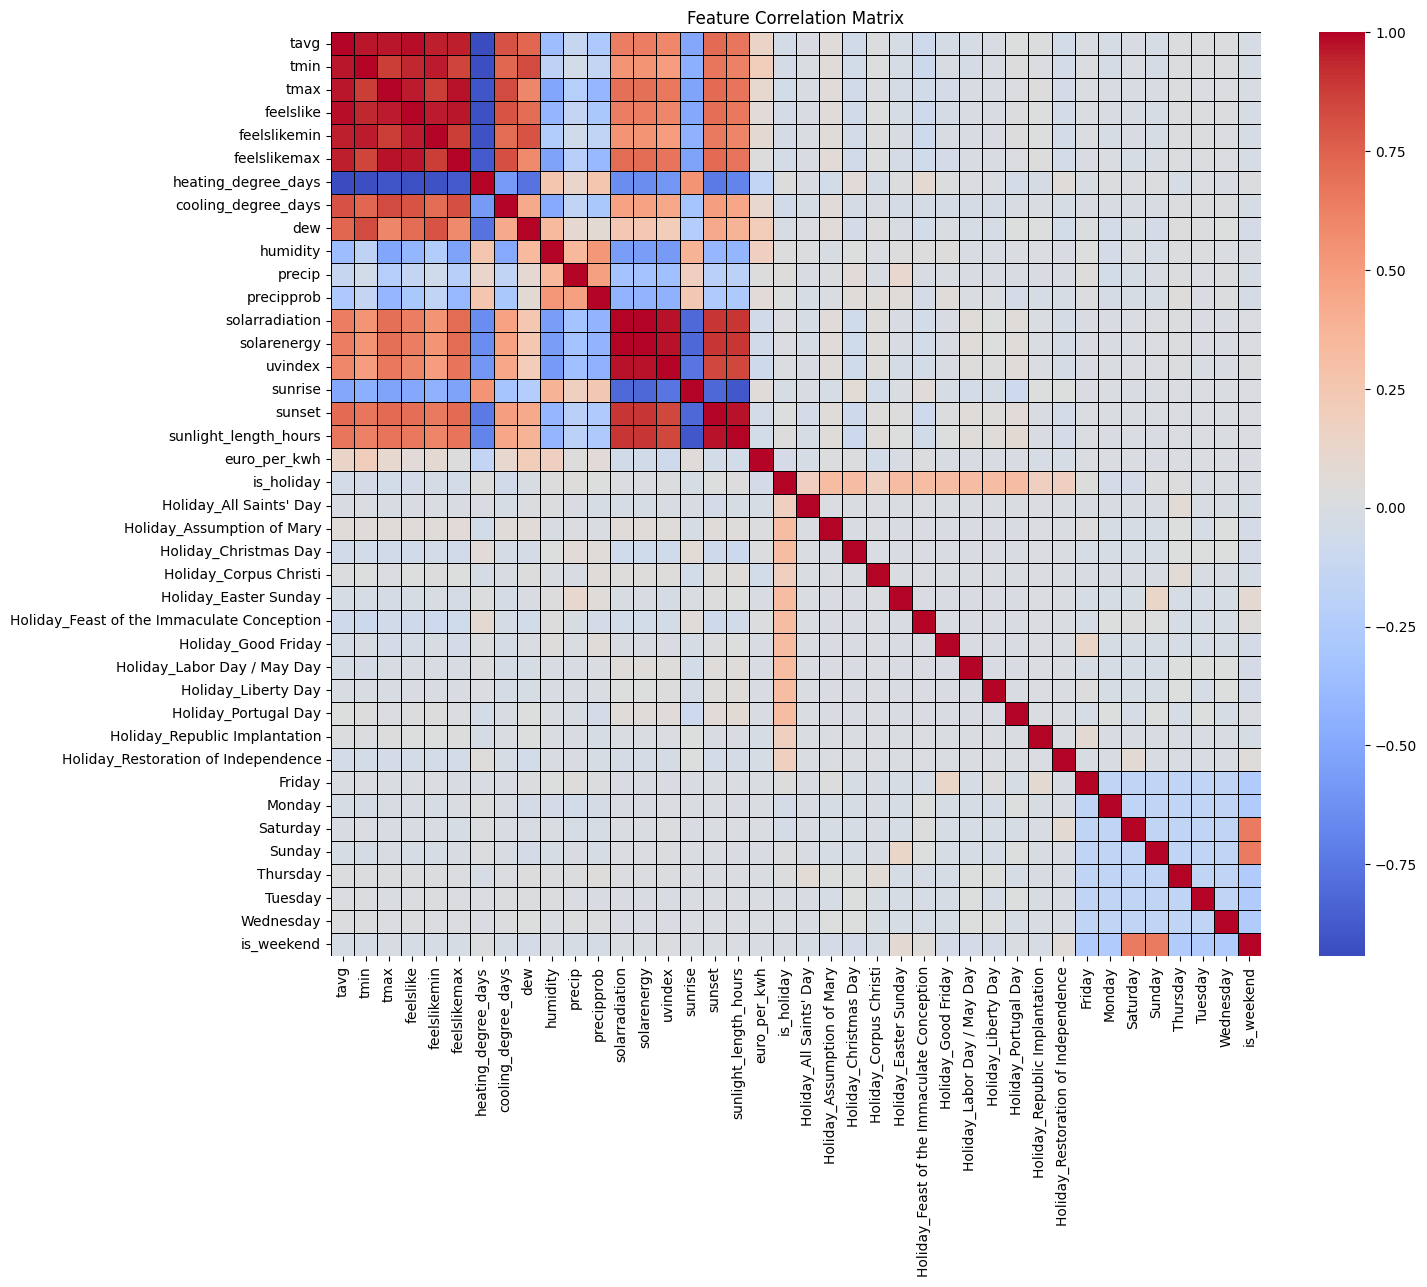

In [59]:
plt.figure(figsize=(15,12))

ax = sns.heatmap(explanatory_variables_df.corr(), cmap='coolwarm', fmt=".2f", linewidths=.5, linecolor='black')

plt.title("Feature Correlation Matrix")
plt.show()

In [60]:
vif_data = pd.DataFrame()
vif_data["Feature"] = explanatory_variables_df.columns
vif_data["VIF"] = [variance_inflation_factor(explanatory_variables_df.values, i) for i in range(explanatory_variables_df.shape[1])]
vif_data

/Users/luiz/Documents/Projects/ieor_4578_project1/venv/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Feature          VIF
0                                         tavg   193.025367
1                                         tmin          inf
2                                         tmax          inf
3                                    feelslike   197.857259
4                                 feelslikemin    44.986940
5                                 feelslikemax    57.071586
6                          heating_degree_days          inf
7                          cooling_degree_days          inf
8                                          dew    78.722501
9                                     humidity    50.034273
10                                      precip     1.444556
11                                  precipprob     1.993020
12                              solarradiation  5670.184540
13                                 solarenergy  5614.752742
14                                     uvindex    21.416583
15                                     sunrise     7.480181
16                                      sunset    31.551302
17                       sunlight_length_hours    41.641979
18                                euro_per_kwh     1.417100
19                                  is_holiday          inf
20                     Holiday_All Saints' Day          inf
21                  Holiday_Assumption of Mary          inf
22                       Holiday_Christmas Day          inf
23                      Holiday_Corpus Christi          inf
24                       Holiday_Easter Sunday          inf
25  Holiday_Feast of the Immaculate Conception          inf
26                         Holiday_Good Friday          inf
27                 Holiday_Labor Day / May Day          inf
28                         Holiday_Liberty Day          inf
29                        Holiday_Portugal Day          inf
30               Holiday_Republic Implantation          inf
31         Holiday_Restoration of Independence          inf
32                                      Friday          inf
33                                      Monday          inf
34                                    Saturday          inf
35                                      Sunday          inf
36                                    Thursday          inf
37                                     Tuesday          inf
38                                   Wednesday          inf
39                                  is_weekend          inf

In [61]:
features_to_keep = [
    'heating_degree_days',
    'cooling_degree_days',
    'precip',
    'precipprob',
    'is_holiday',
    'sunlight_length_hours',
    'is_weekend',
]

filtered_explanatory_variables_df = explanatory_variables_df[features_to_keep]

filtered_explanatory_variables_df.head()

heating_degree_days  cooling_degree_days  precip  precipprob  \
date                                                                       
2012-01-01             6.578559                  0.0   0.000         0.0   
2012-01-02             6.659918                  0.0   0.111         1.0   
2012-01-03             7.977833                  0.0   0.000         0.0   
2012-01-04             6.335269                  0.0   0.000         0.0   
2012-01-05             7.437771                  0.0   0.000         0.0   

            is_holiday  sunlight_length_hours  is_weekend  
date                                                       
2012-01-01           0                   10.0           1  
2012-01-02           0                   10.0           0  
2012-01-03           0                   10.0           0  
2012-01-04           0                   10.0           0  
2012-01-05           0                   10.0           0

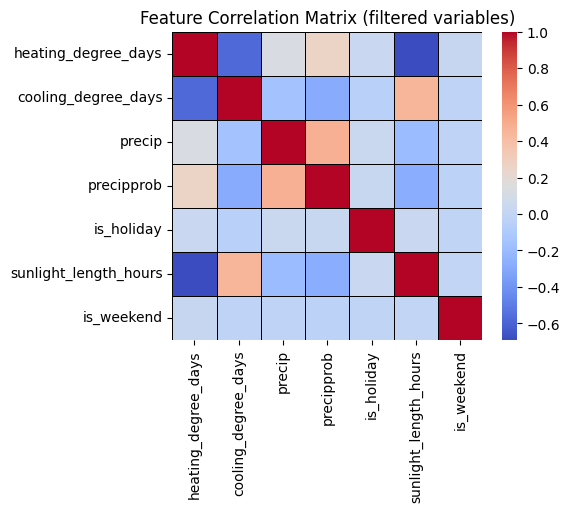

In [62]:
plt.figure(figsize=(5,4))

ax = sns.heatmap(filtered_explanatory_variables_df.corr(), cmap='coolwarm', fmt=".2f", linewidths=.5, linecolor='black')

plt.title("Feature Correlation Matrix (filtered variables)")
plt.show()

In [63]:
vif_data = pd.DataFrame()
vif_data["Feature"] = filtered_explanatory_variables_df.columns
vif_data["VIF"] = [variance_inflation_factor(filtered_explanatory_variables_df.values, i) for i in range(filtered_explanatory_variables_df.shape[1])]
vif_data

Feature       VIF
0    heating_degree_days  2.371616
1    cooling_degree_days  2.070326
2                 precip  1.415471
3             precipprob  1.931033
4             is_holiday  1.033935
5  sunlight_length_hours  3.917243
6             is_weekend  1.398500

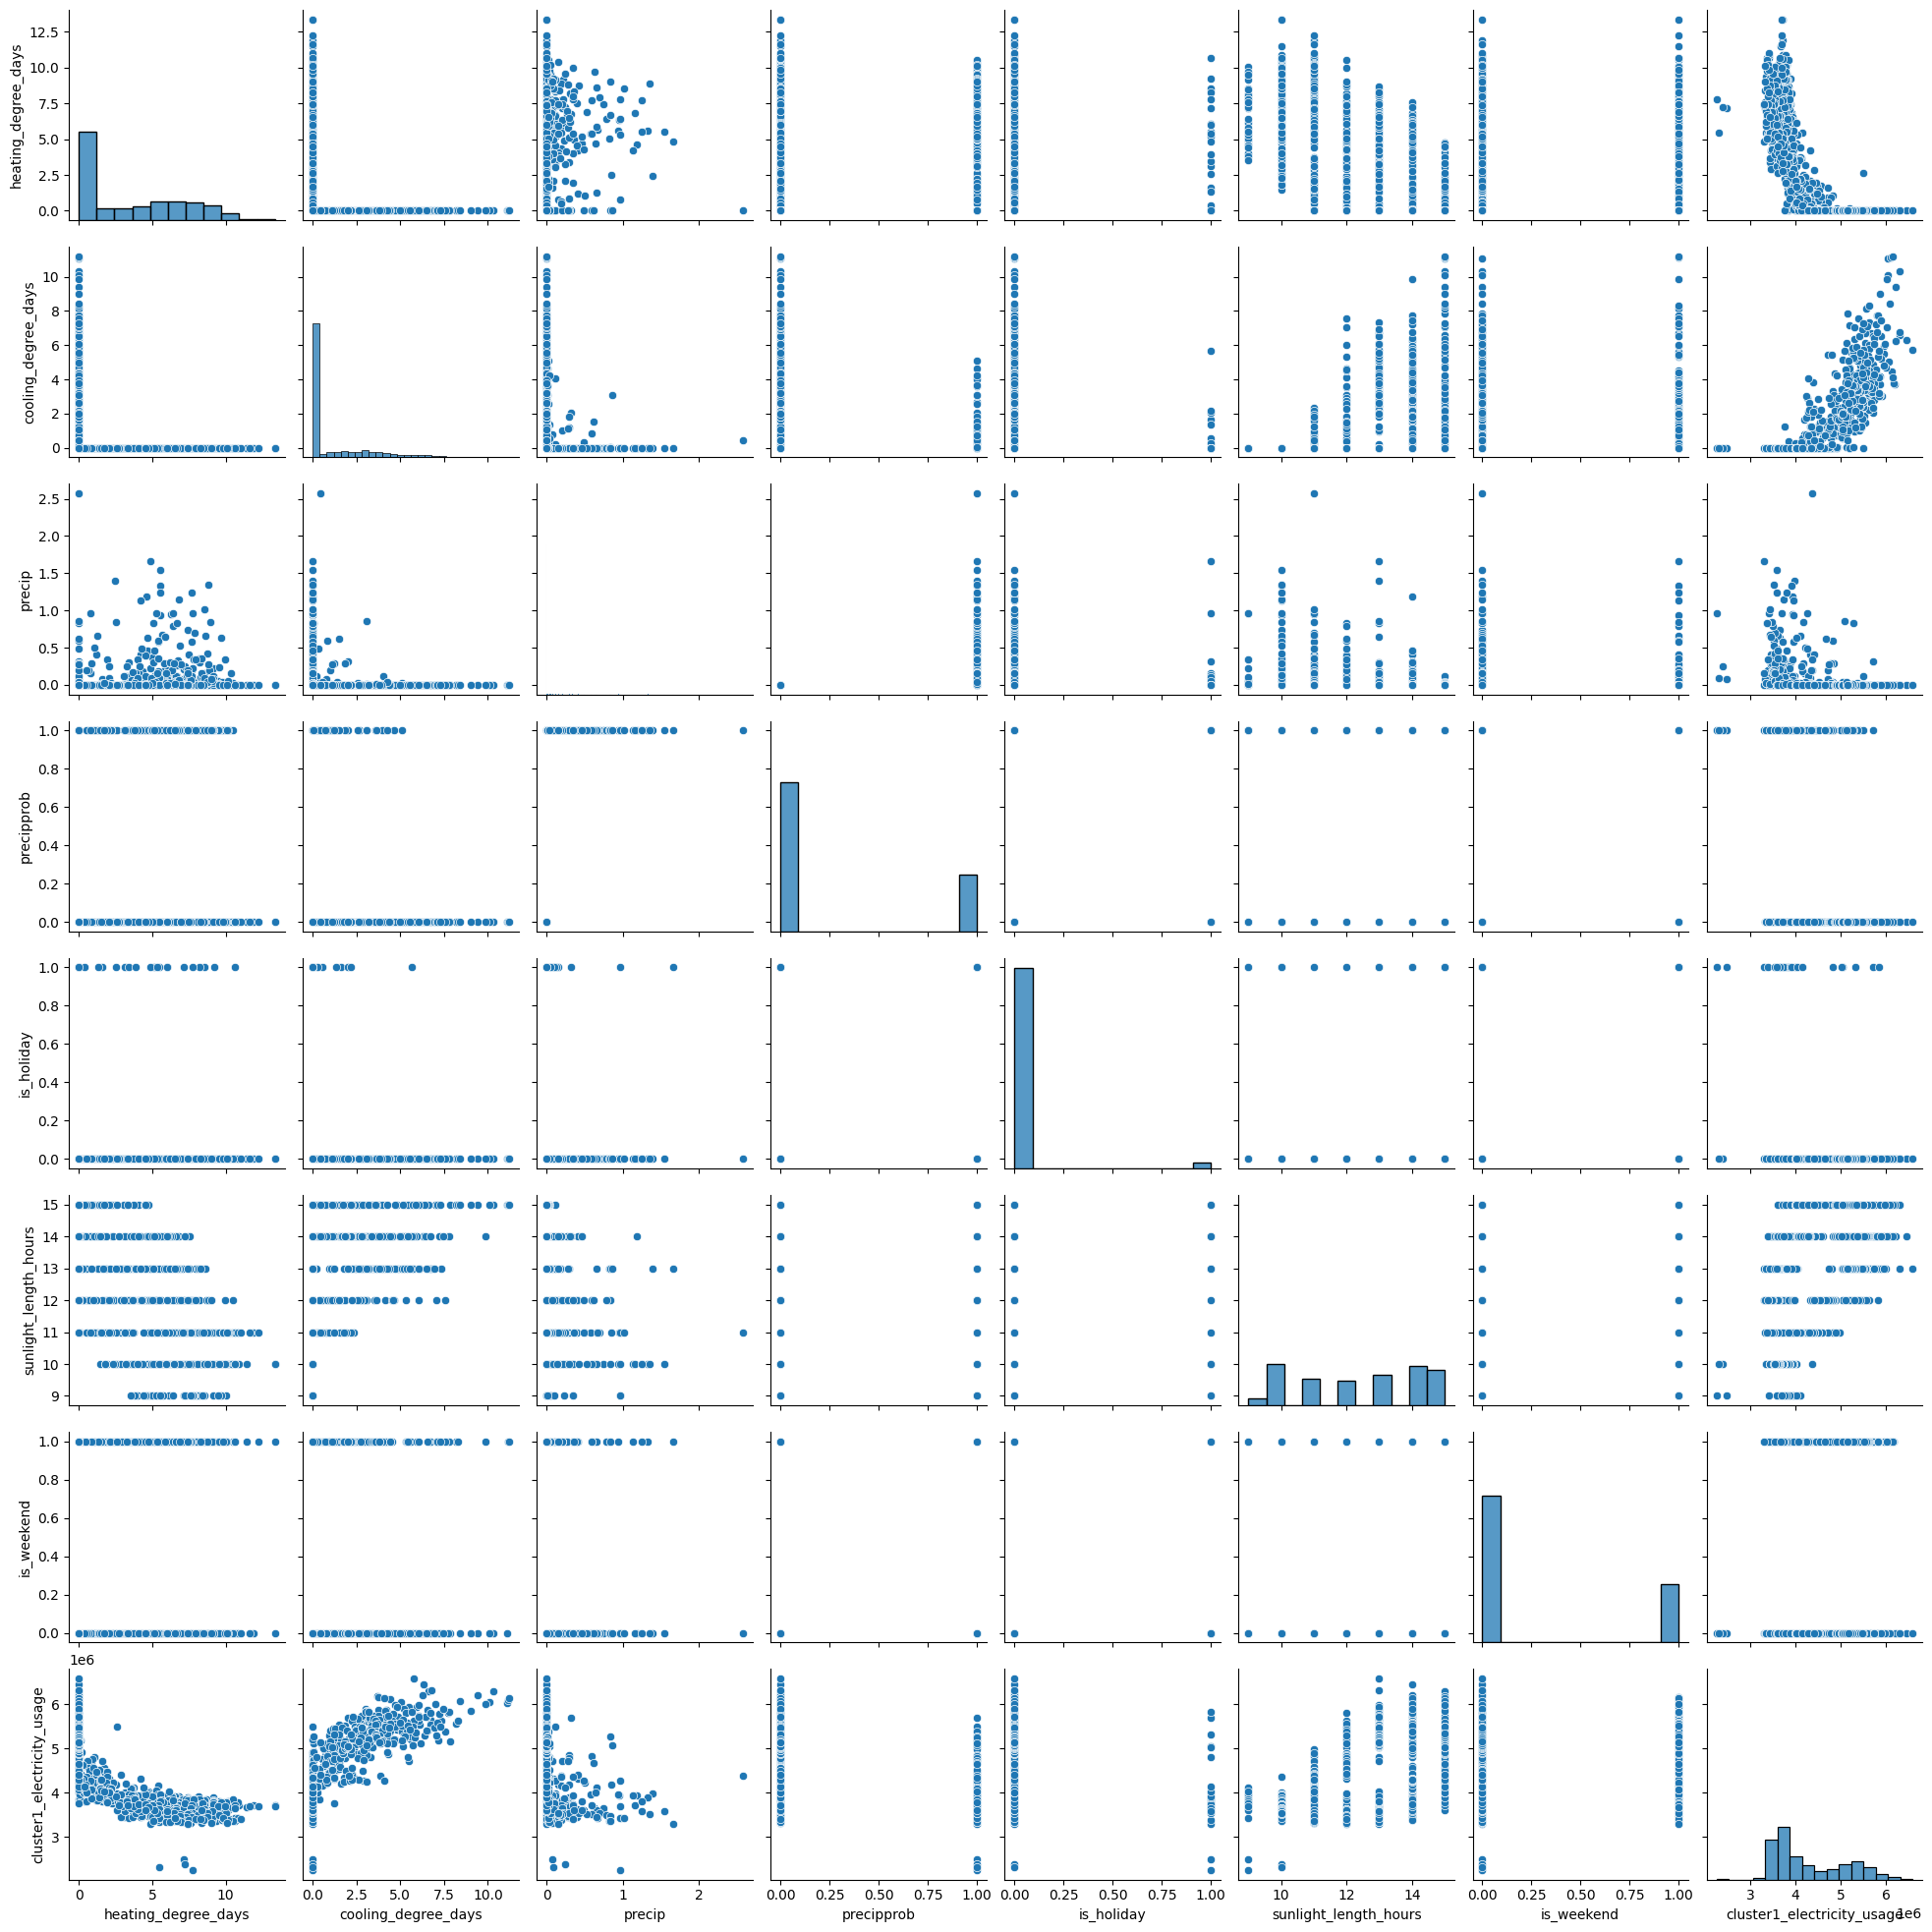

In [64]:
sns.pairplot(pd.concat([filtered_explanatory_variables_df, cluster_1_train_total], join='inner', axis=1))
plt.show()

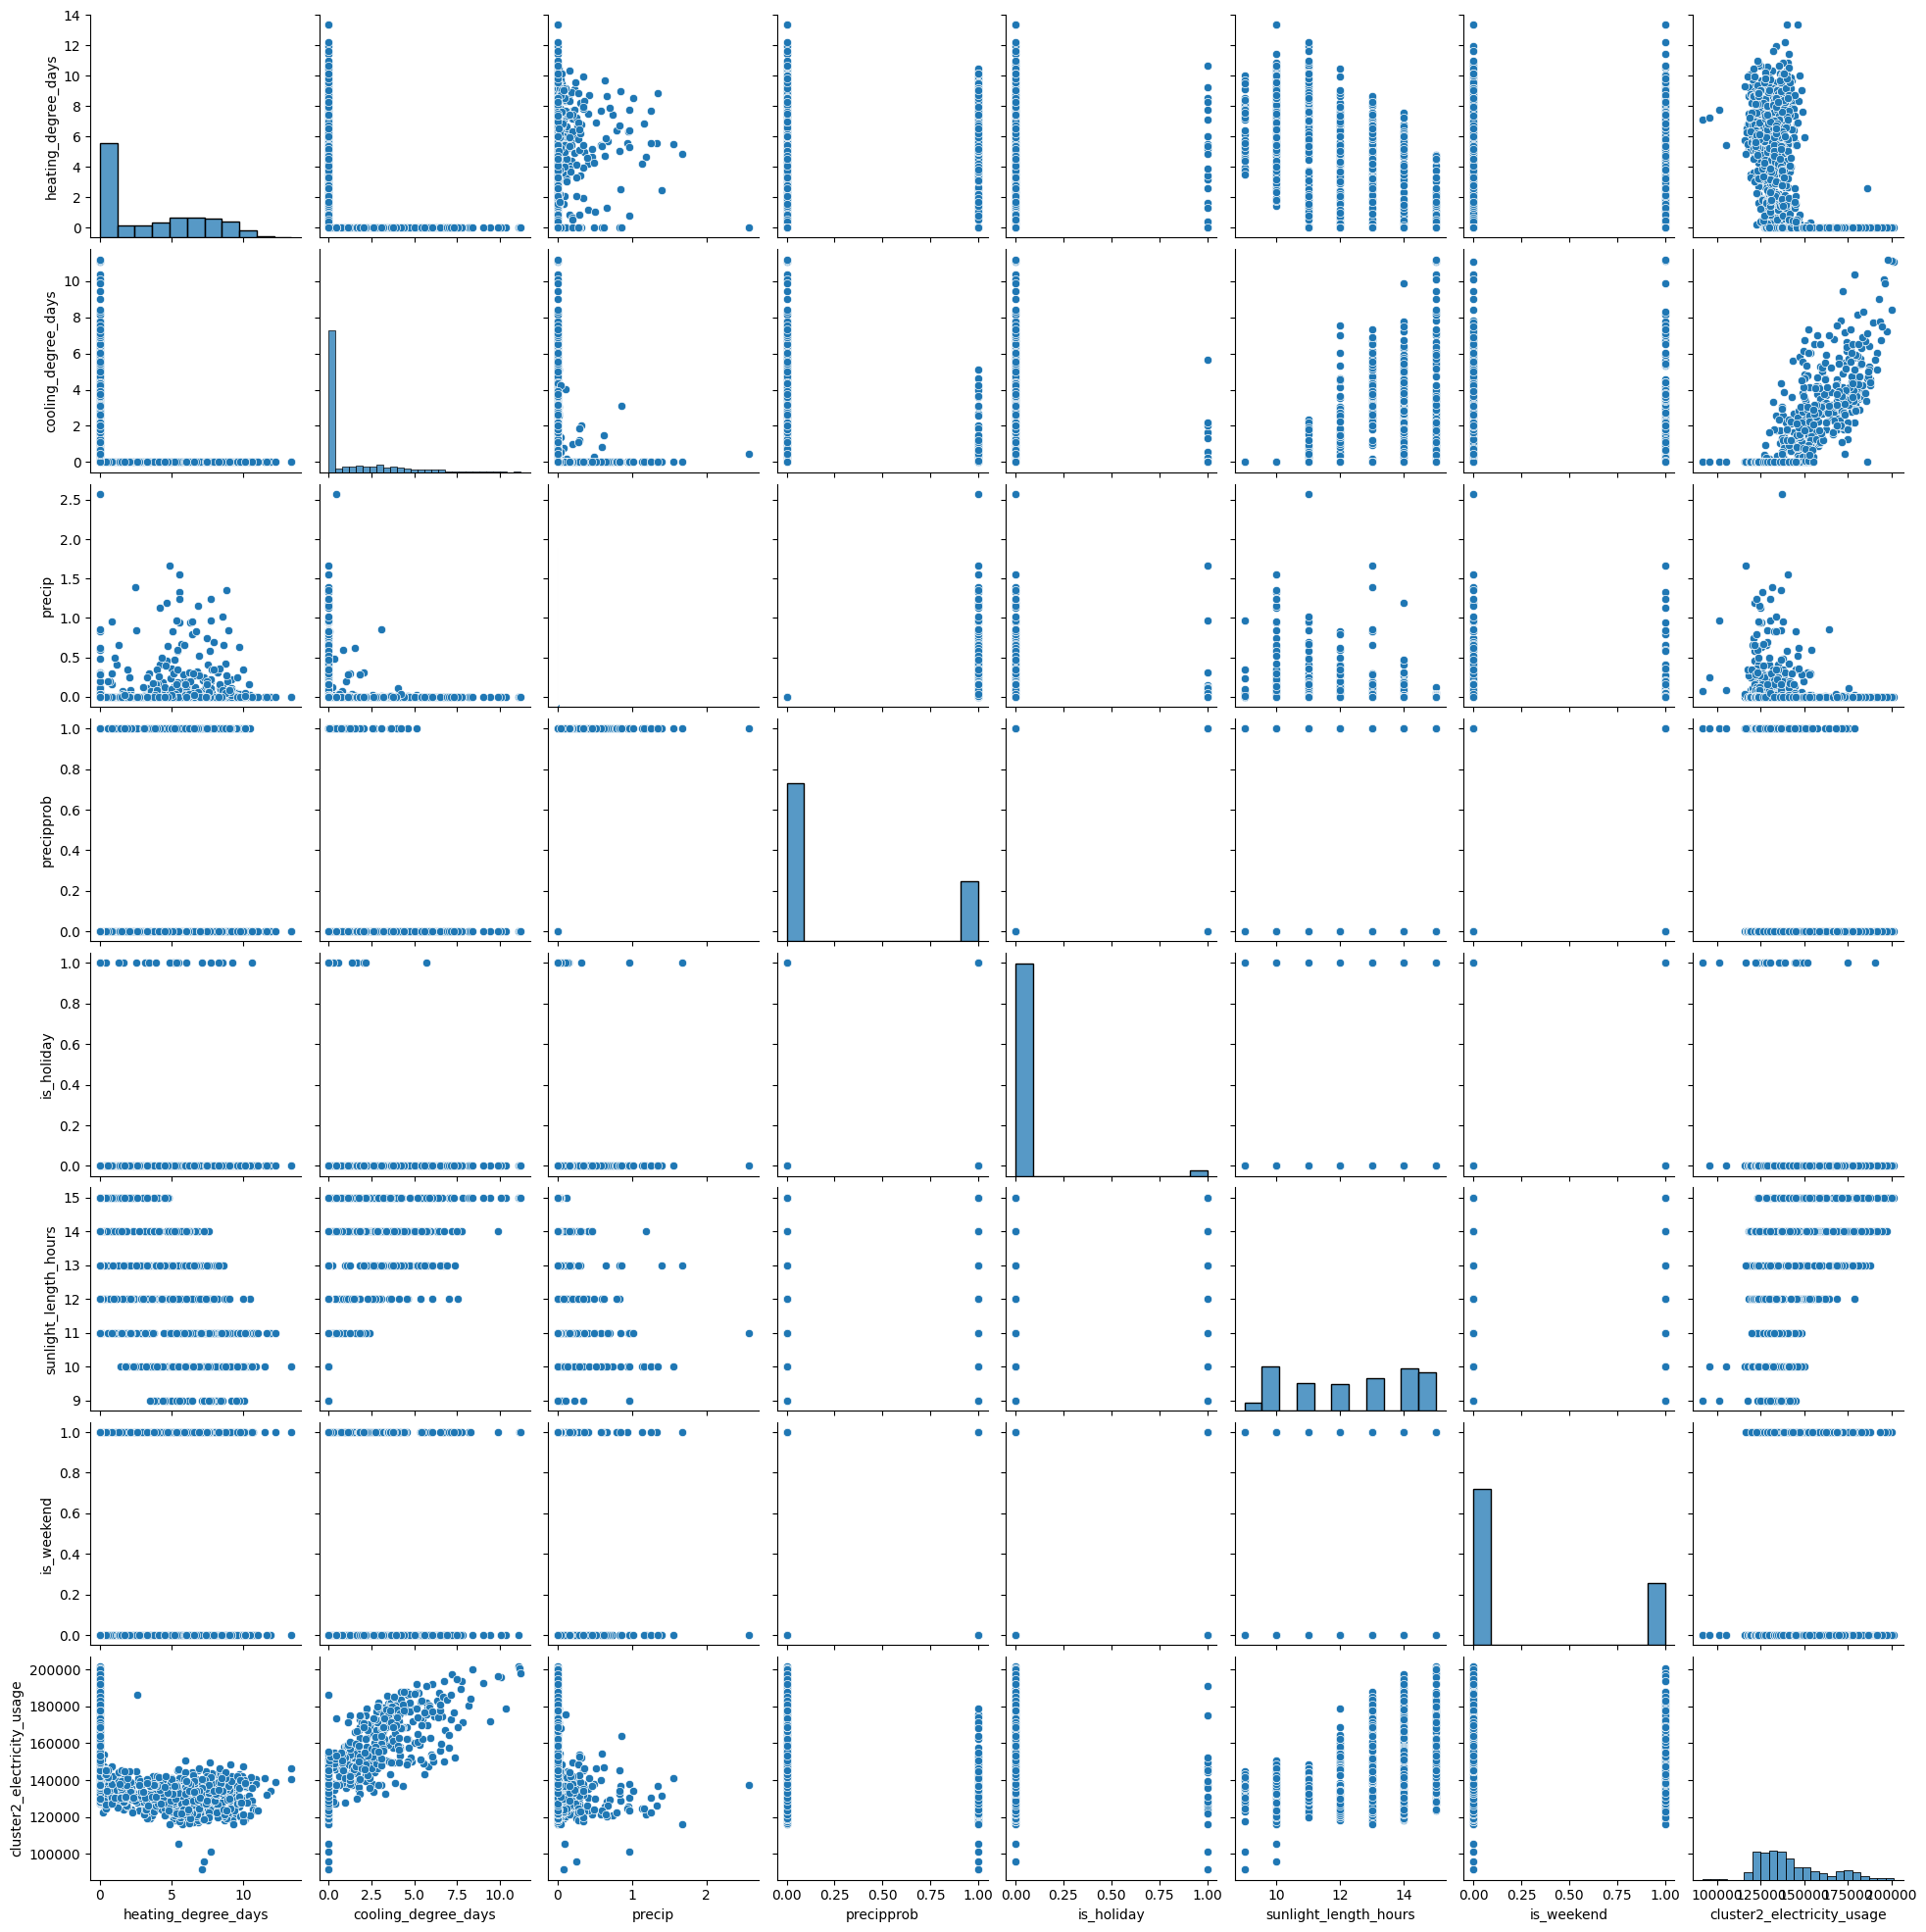

In [65]:
sns.pairplot(pd.concat([filtered_explanatory_variables_df, cluster_2_train_total], join='inner', axis=1))
plt.show()

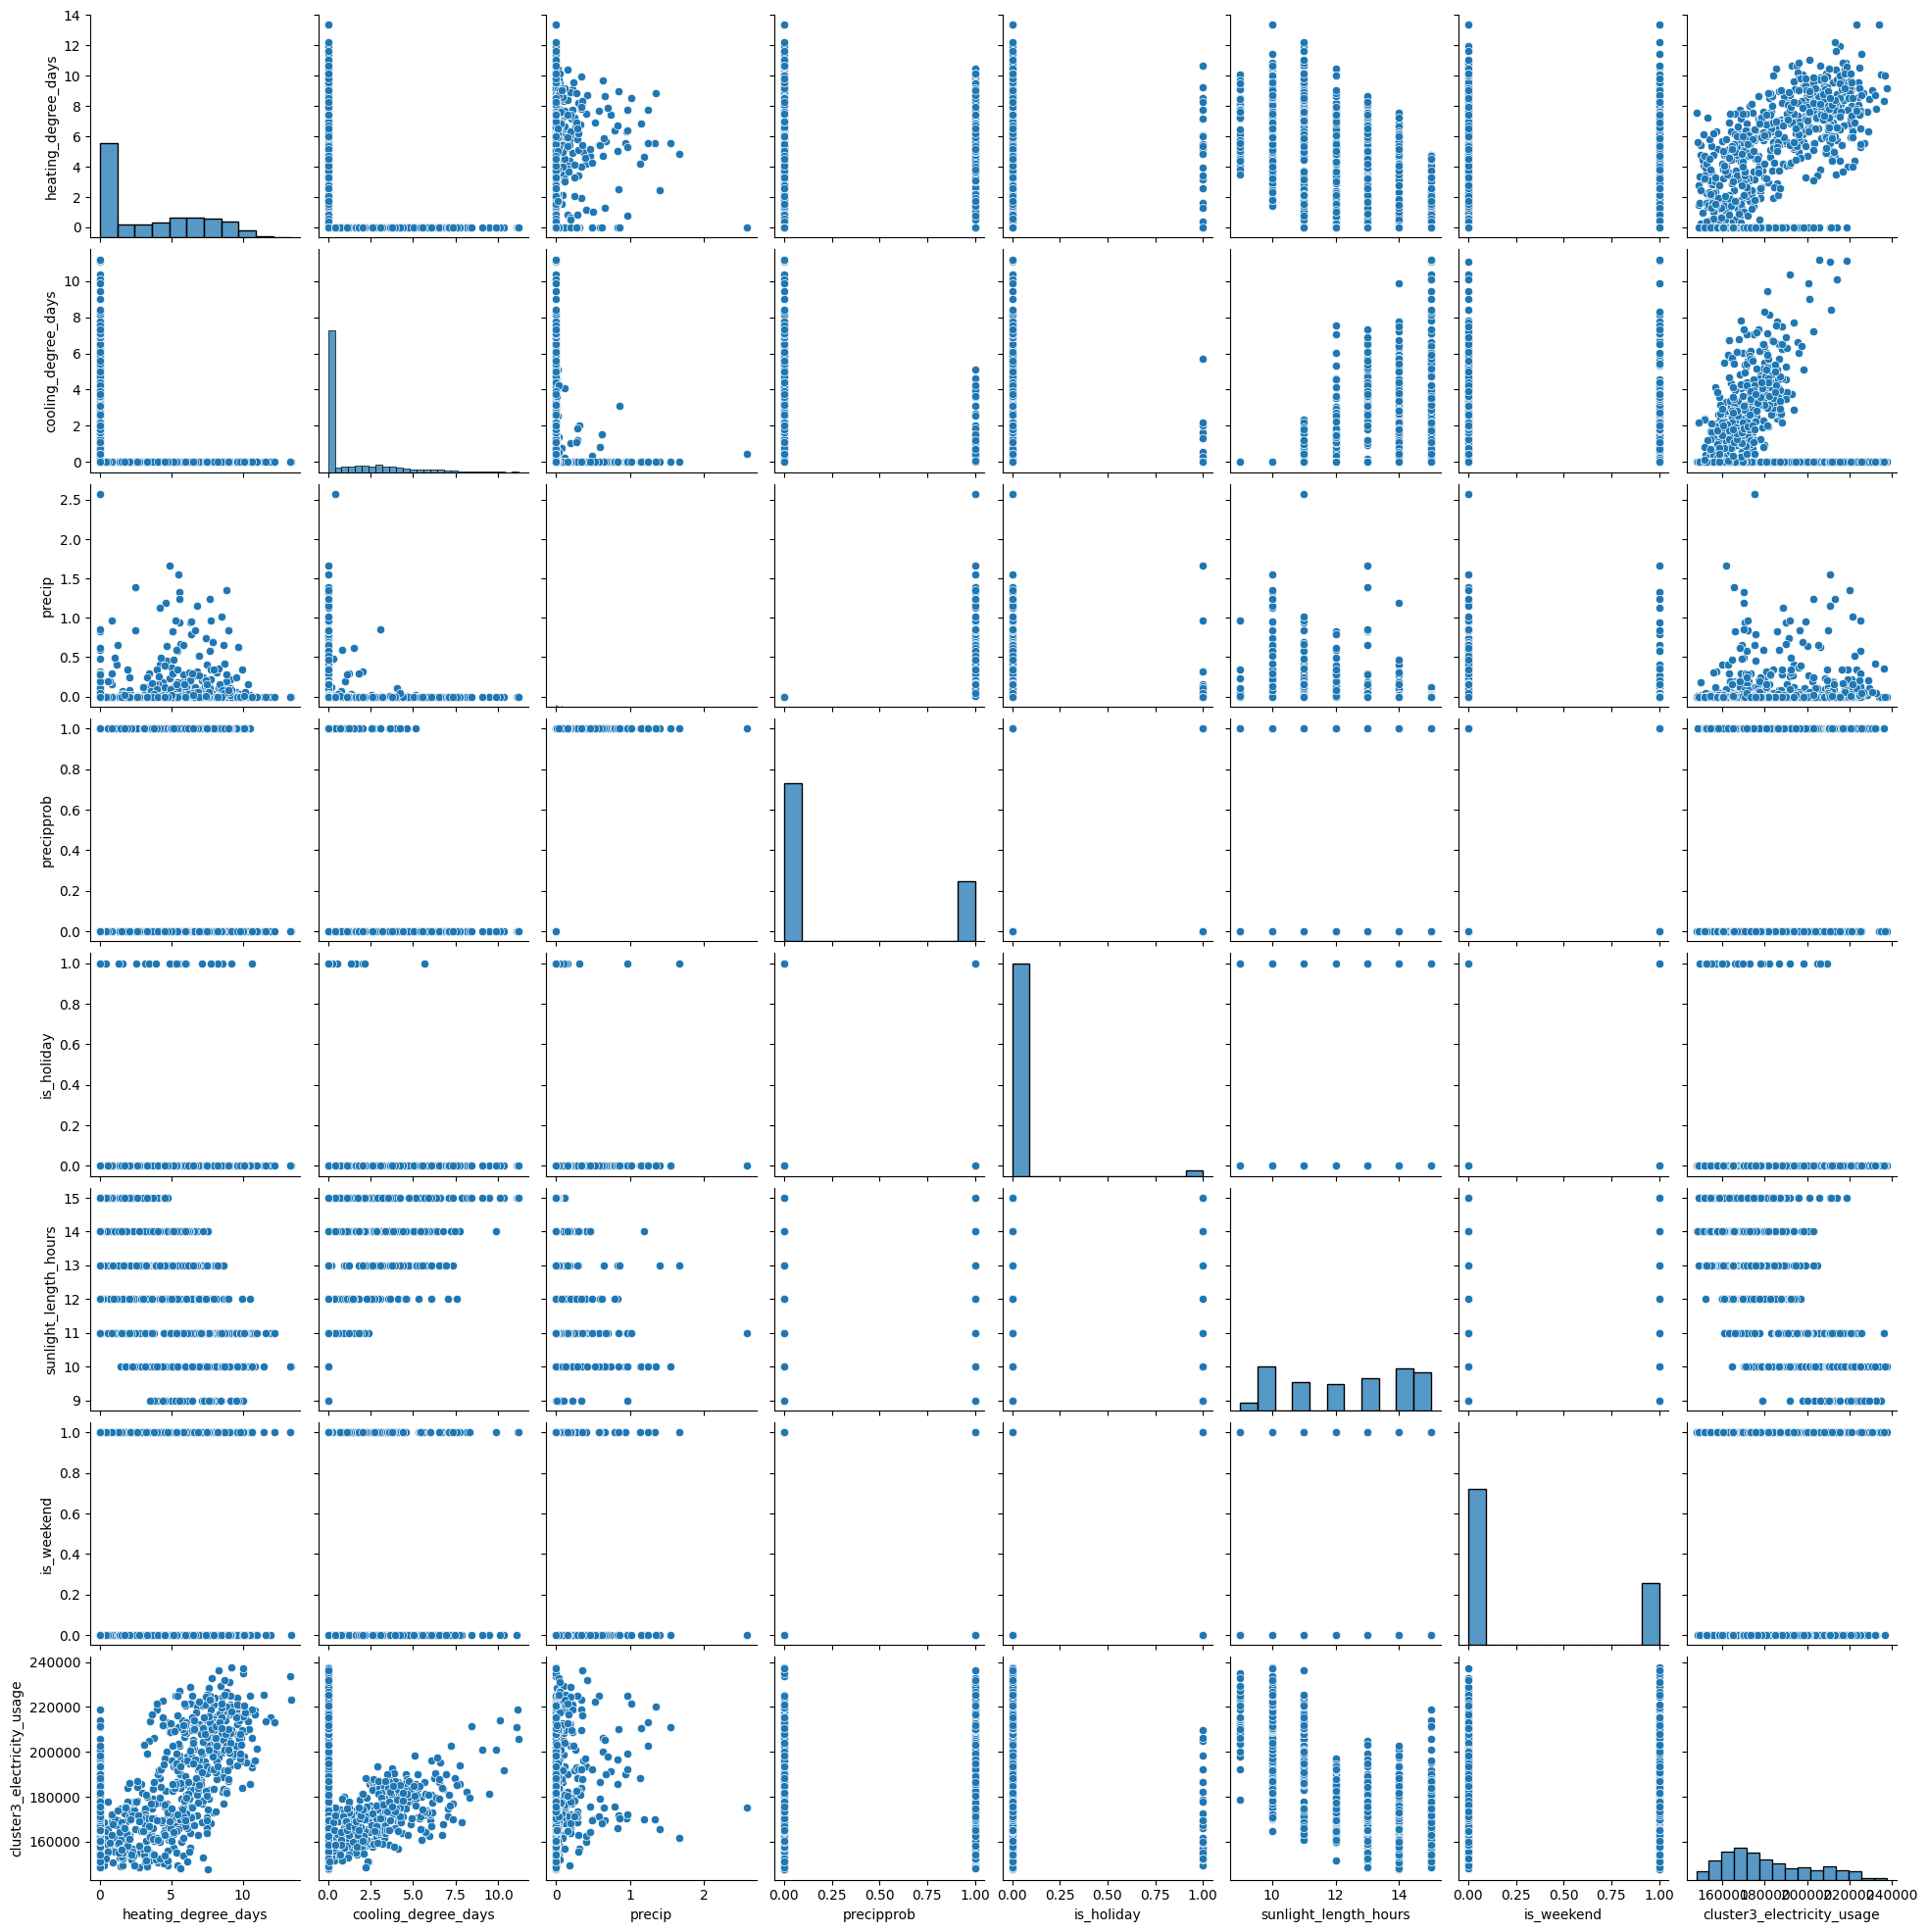

In [66]:
sns.pairplot(pd.concat([filtered_explanatory_variables_df, cluster_3_train_total], join='inner', axis=1))
plt.show()

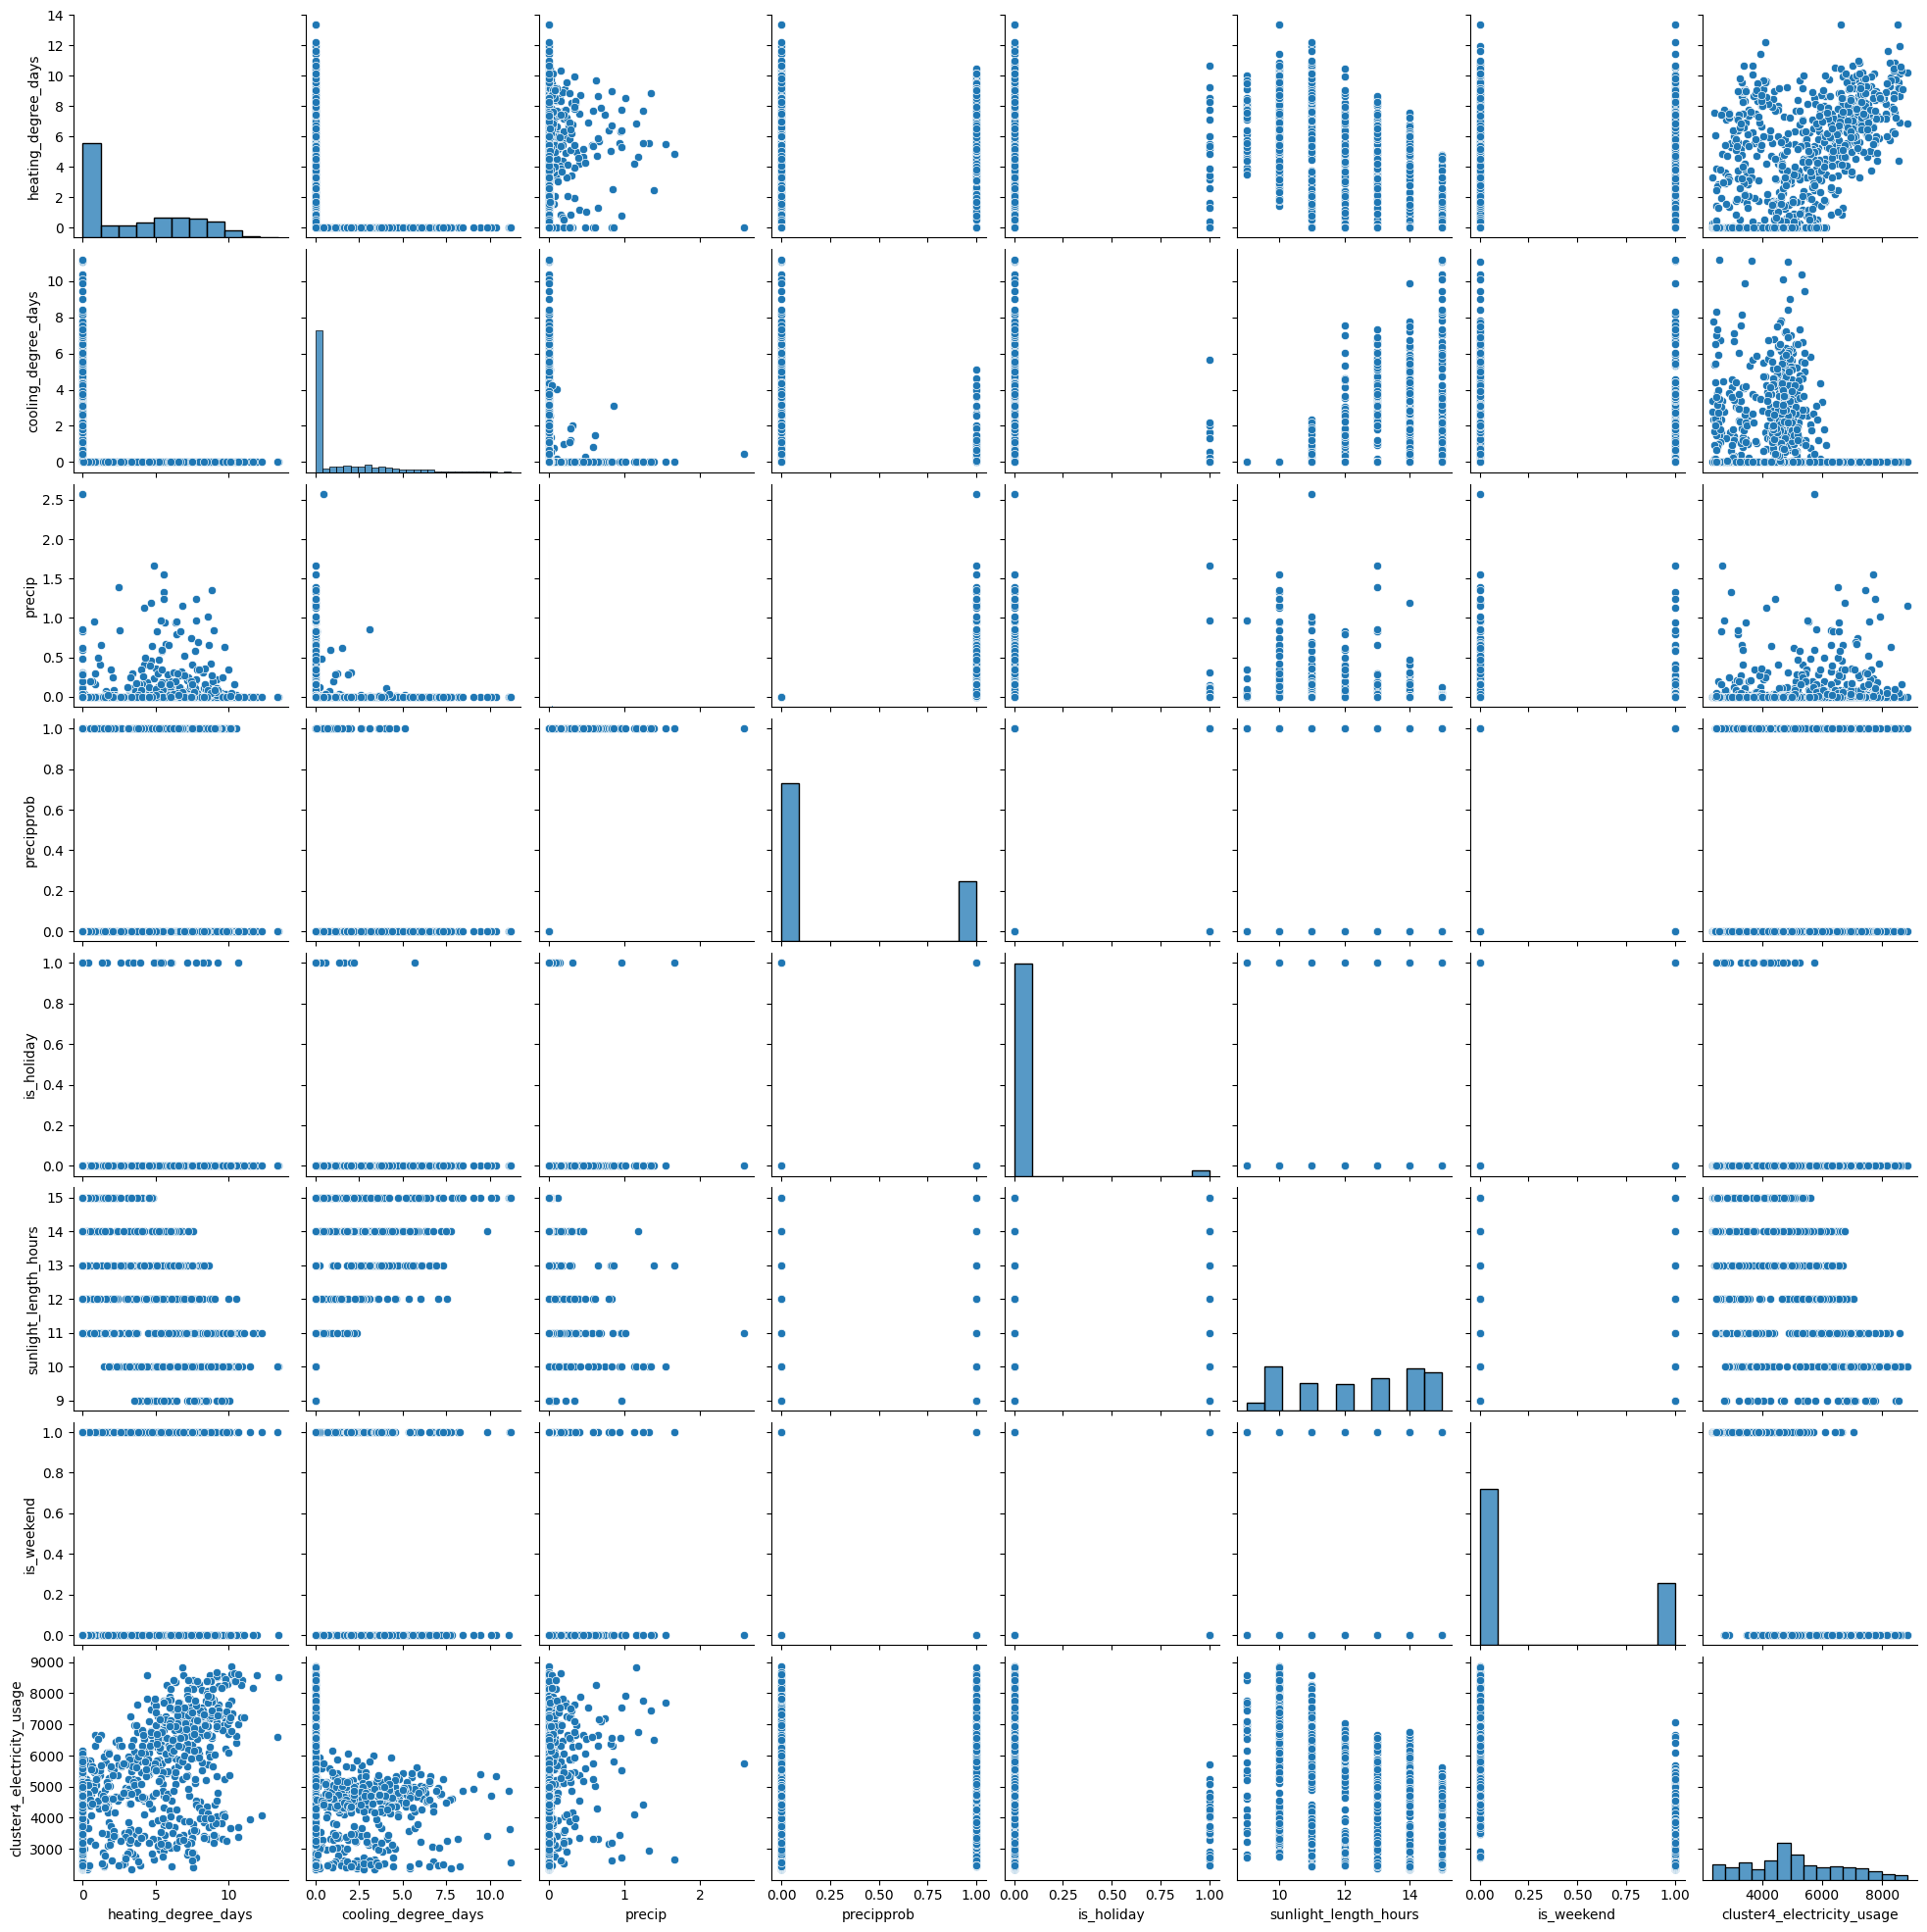

In [67]:
sns.pairplot(pd.concat([filtered_explanatory_variables_df, cluster_4_train_total], join='inner', axis=1))
plt.show()

In [68]:
total_usage_and_features_train_df = pd.concat([
    filtered_explanatory_variables_df,
    cluster_1_train_total,
    cluster_2_train_total,
    cluster_3_train_total,
    cluster_4_train_total], join='inner', axis=1)

total_usage_and_features_train_df.head()

heating_degree_days  cooling_degree_days  precip  precipprob  \
date                                                                       
2012-01-02             6.659918                  0.0   0.111         1.0   
2012-01-03             7.977833                  0.0   0.000         0.0   
2012-01-04             6.335269                  0.0   0.000         0.0   
2012-01-05             7.437771                  0.0   0.000         0.0   
2012-01-06             8.166583                  0.0   0.000         0.0   

            is_holiday  sunlight_length_hours  is_weekend  \
date                                                        
2012-01-02           0                   10.0           0   
2012-01-03           0                   10.0           0   
2012-01-04           0                   10.0           0   
2012-01-05           0                   10.0           0   
2012-01-06           0                   10.0           0   

            cluster1_electricity_usage  cluster2_electricity_usage  \
date                                                                 
2012-01-02                3.851342e+06               132667.904259   
2012-01-03                3.864771e+06               135648.923226   
2012-01-04                3.881005e+06               132962.471245   
2012-01-05                3.898272e+06               134978.916606   
2012-01-06                3.911079e+06               140869.711004   

            cluster3_electricity_usage  cluster4_electricity_usage  
date                                                                
2012-01-02               221086.122438                 7393.560296  
2012-01-03               221263.453785                 8310.458649  
2012-01-04               221351.844925                 8343.766853  
2012-01-05               214697.939337                 8155.724645  
2012-01-06               215888.748539                 8109.149412

In [69]:
total_usage_and_features_val_df = pd.concat([
    filtered_explanatory_variables_df,
    cluster_1_val_total,
    cluster_2_val_total,
    cluster_3_val_total,
    cluster_4_val_total], join='inner', axis=1)

total_usage_and_features_val_df.head()

heating_degree_days  cooling_degree_days  precip  precipprob  \
date                                                                       
2014-09-14                  0.0             2.530760   0.000         0.0   
2014-09-15                  0.0             3.254270   0.375         1.0   
2014-09-16                  0.0             2.870421   0.010         1.0   
2014-09-17                  0.0             2.122794   0.004         1.0   
2014-09-18                  0.0             1.501680   0.020         1.0   

            is_holiday  sunlight_length_hours  is_weekend  \
date                                                        
2014-09-14           0                   12.0           1   
2014-09-15           0                   12.0           0   
2014-09-16           0                   12.0           0   
2014-09-17           0                   12.0           0   
2014-09-18           0                   12.0           0   

            cluster1_electricity_usage  cluster2_electricity_usage  \
date                                                                 
2014-09-14                5.044370e+06               164555.351650   
2014-09-15                4.964791e+06               163596.599523   
2014-09-16                4.847313e+06               162266.686432   
2014-09-17                4.737102e+06               161630.549015   
2014-09-18                4.586708e+06               161273.362720   

            cluster3_electricity_usage  cluster4_electricity_usage  
date                                                                
2014-09-14               161411.276184                 2521.746394  
2014-09-15               169324.023816                 4957.860043  
2014-09-16               172148.391726                 5288.985062  
2014-09-17               170379.105672                 5611.830573  
2014-09-18               174268.529596                 5068.016156

In [70]:
common_features = features_to_keep

X_1_train = total_usage_and_features_train_df[common_features]
y_1_train = total_usage_and_features_train_df['cluster1_electricity_usage']

X_1_val = total_usage_and_features_val_df[common_features]
y_1_val = total_usage_and_features_val_df['cluster1_electricity_usage']

X_2_train = total_usage_and_features_train_df[common_features]
y_2_train = total_usage_and_features_train_df['cluster2_electricity_usage']

X_2_val = total_usage_and_features_val_df[common_features]
y_2_val = total_usage_and_features_val_df['cluster2_electricity_usage']

X_3_train = total_usage_and_features_train_df[common_features]
y_3_train = total_usage_and_features_train_df['cluster3_electricity_usage']

X_3_val = total_usage_and_features_val_df[common_features]
y_3_val = total_usage_and_features_val_df['cluster3_electricity_usage']

X_4_train = total_usage_and_features_train_df[common_features]
y_4_train = total_usage_and_features_train_df['cluster4_electricity_usage']

X_4_val = total_usage_and_features_val_df[common_features]
y_4_val = total_usage_and_features_val_df['cluster4_electricity_usage']

train_dates = list(cluster_1_train_total.index)
val_dates = list(cluster_1_val_total.index)

### Decision Tree

In [71]:
def show_tree_regressor_results(X_train, y_train, X_val, y_val):
    tree_regressor = DecisionTreeRegressor(random_state=42, max_depth=10)
    tree_regressor.fit(X_train, y_train)
    
    importances = tree_regressor.feature_importances_
    
    # Create a DataFrame to store feature names and importances
    feature_importance_df = pd.DataFrame({'Feature': common_features, 'Importance': importances})
    
    # Sort the DataFrame by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    # Print the most important features
    print("\nFeature Importances:")
    print(feature_importance_df.to_string(index=False))
    
    y_train_pred = tree_regressor.predict(X_train)
    y_val_pred = tree_regressor.predict(X_val)
    
    # Evaluate the model (Regression Example)
    mse = mean_squared_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    mape = mean_absolute_percentage_error(y_val, y_val_pred)
    print(f"\nMean Squared Error (MSE): {mse}")
    print(f"R-squared: {r2 * 100:.2f}%")
    print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
    
    ax.plot(pd.Series(y_train, index=train_dates), label='training (actual)', color='black', alpha=1)
    ax.plot(pd.Series(y_train_pred, index=cluster_1_train_total.index), color='tab:blue', linestyle='--', label='training (predicted)')
    ax.plot(pd.Series(y_val, index=val_dates), label='validation (actual)', color='grey', alpha=1)
    ax.plot(pd.Series(y_val_pred, index=val_dates), color='tab:orange', linestyle='--', label='validation (predicted)')

    make_axes_human_readable(ax)
    ax.set_title('Total consumption (Decision Tree)')
    ax.set_xlabel('Date')
    ax.set_ylabel('kWh')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

    visualization_tree = DecisionTreeRegressor(random_state=42, max_depth=3) # Only showing the top 2 layers
    visualization_tree.fit(X_train, y_train)

    plt.figure(figsize=(14, 10))
    plot_tree(visualization_tree,
          feature_names=list(common_features),
          filled=True,
          rounded=True)
    plt.show()

Cluster 1

Feature Importances:
              Feature  Importance
  heating_degree_days    0.840808
  cooling_degree_days    0.125599
sunlight_length_hours    0.020701
               precip    0.006265
           is_weekend    0.003369
           precipprob    0.002084
           is_holiday    0.001175

Mean Squared Error (MSE): 156842572992.4719
R-squared: 47.72%
Mean Absolute Percentage Error (MAPE): 7.49%


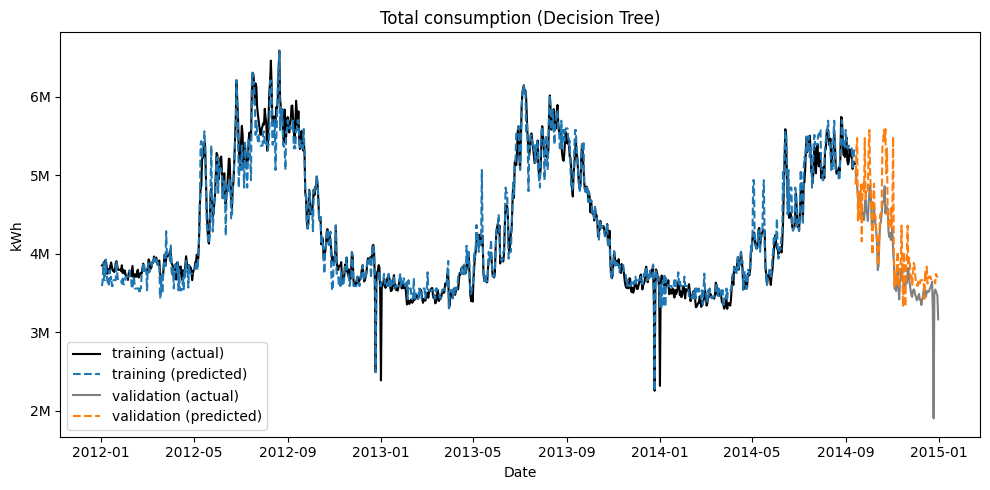

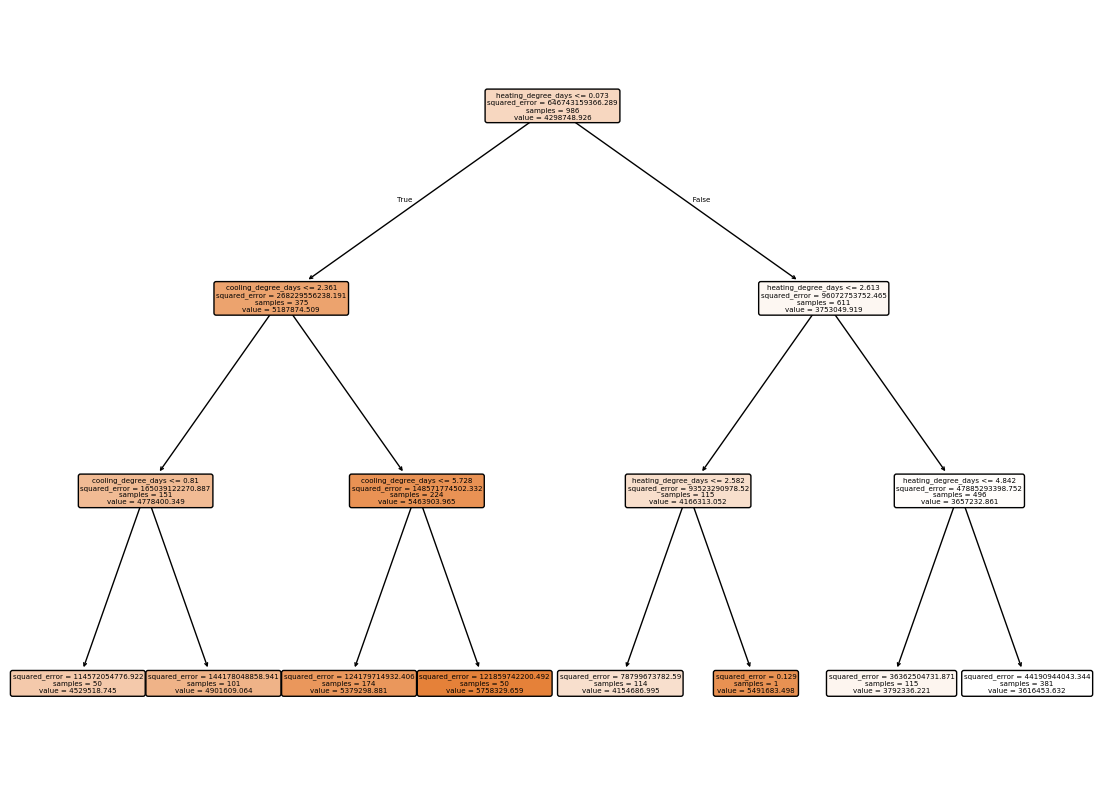

In [72]:
print('Cluster 1')
show_tree_regressor_results(X_1_train, y_1_train, X_1_val, y_1_val)

Cluster 2

Feature Importances:
              Feature  Importance
  cooling_degree_days    0.861852
  heating_degree_days    0.068851
sunlight_length_hours    0.039850
               precip    0.011879
           is_holiday    0.011239
           is_weekend    0.005605
           precipprob    0.000723

Mean Squared Error (MSE): 85609783.87569028
R-squared: 34.61%
Mean Absolute Percentage Error (MAPE): 5.11%


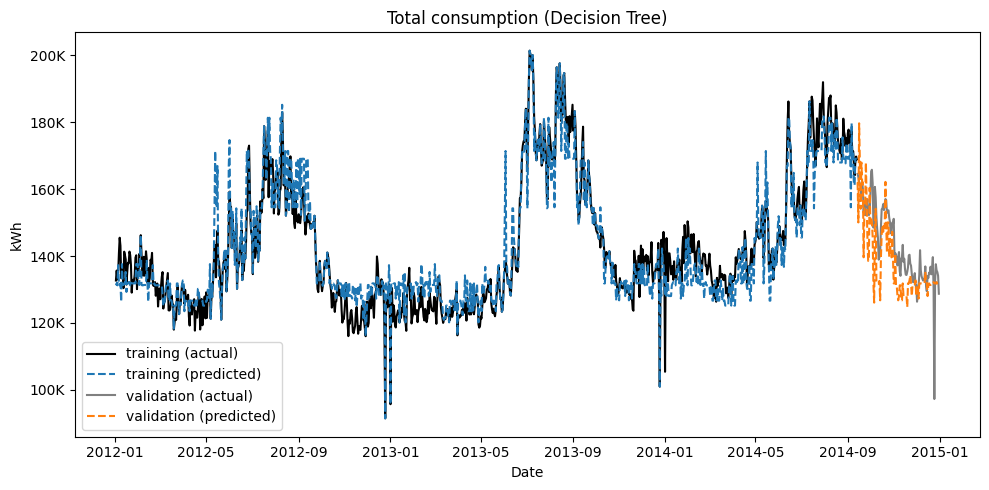

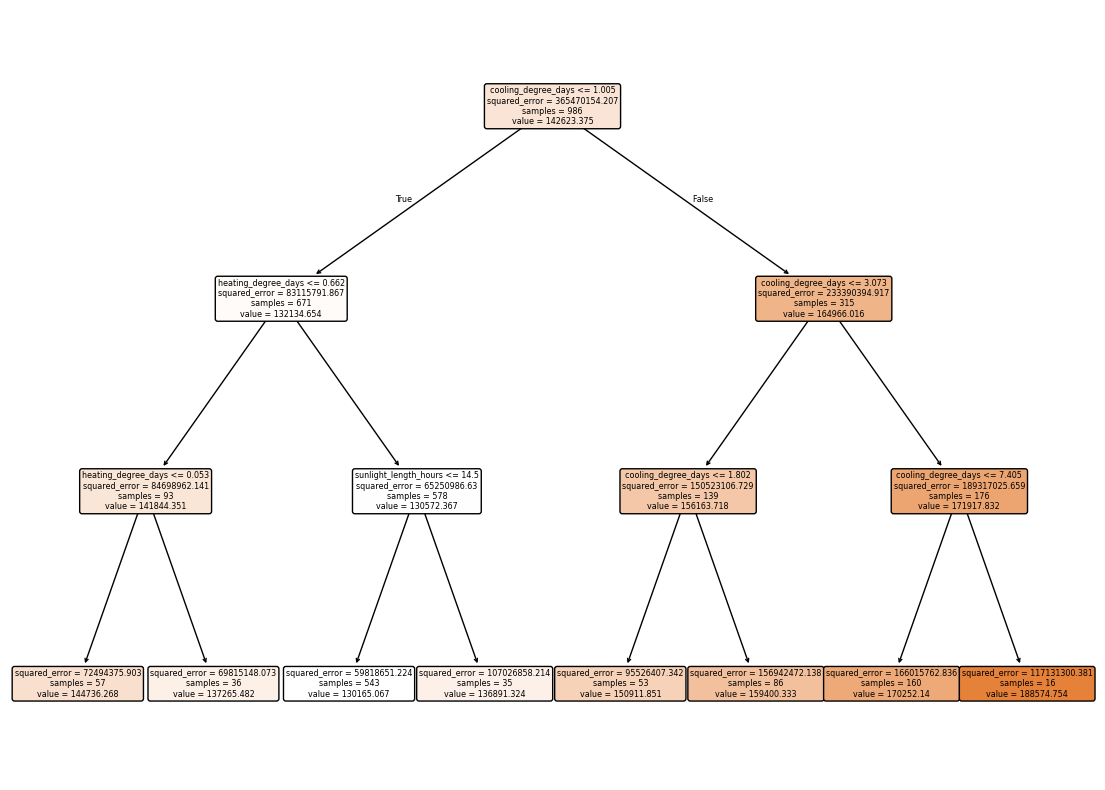

In [73]:
print('Cluster 2')
show_tree_regressor_results(X_2_train, y_2_train, X_2_val, y_2_val)

Cluster 3

Feature Importances:
              Feature  Importance
sunlight_length_hours    0.590647
  heating_degree_days    0.235970
  cooling_degree_days    0.102678
               precip    0.051786
           is_weekend    0.007877
           is_holiday    0.007448
           precipprob    0.003594

Mean Squared Error (MSE): 131590738.47913334
R-squared: 60.94%
Mean Absolute Percentage Error (MAPE): 4.58%


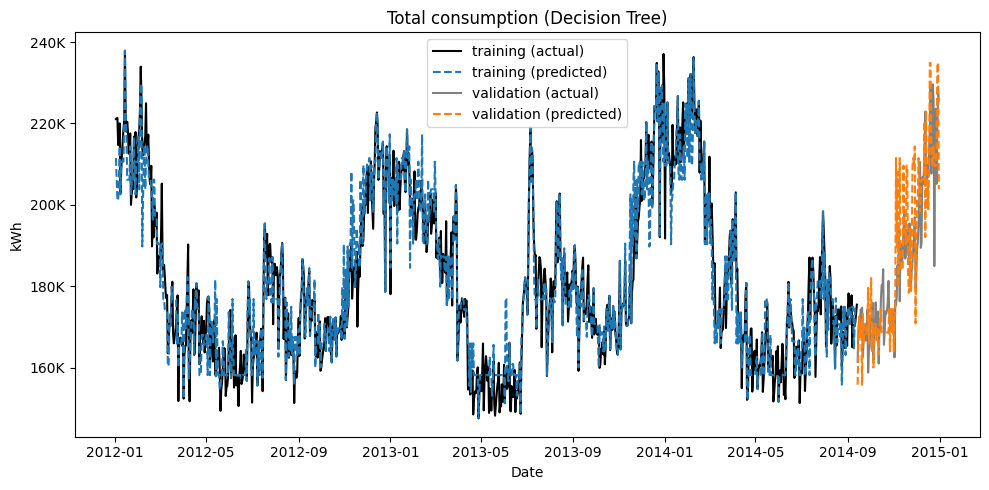

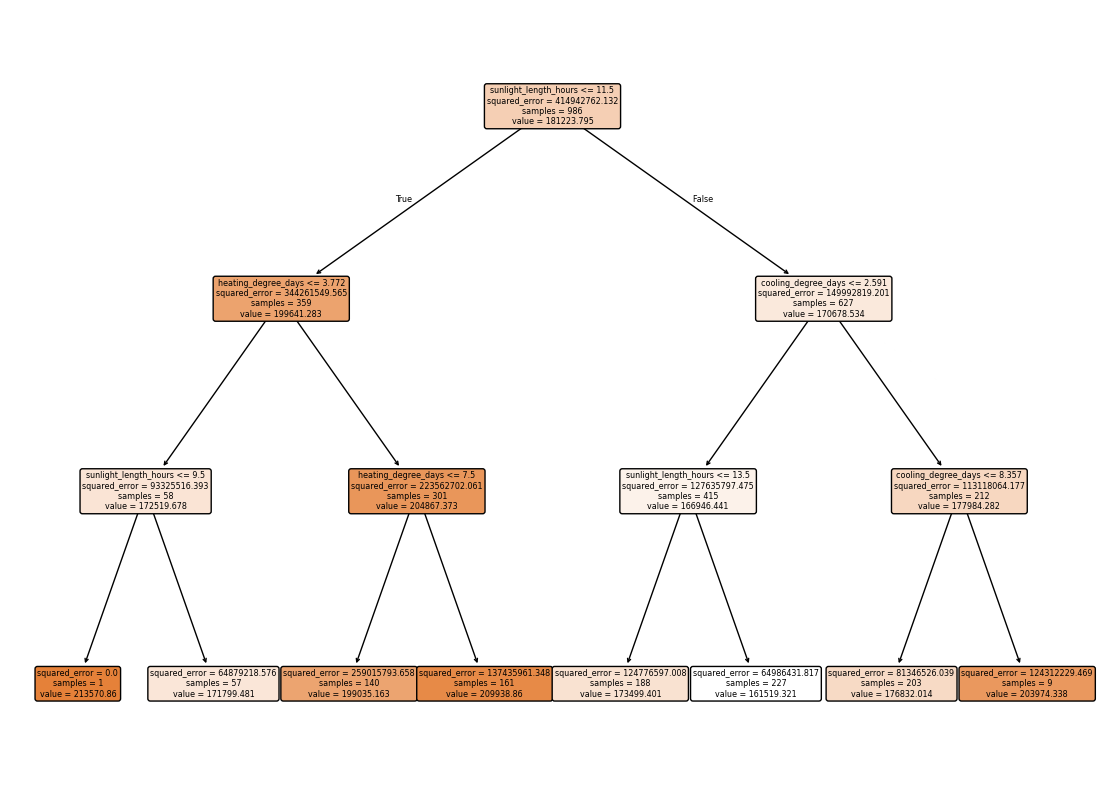

In [74]:
print('Cluster 3')
show_tree_regressor_results(X_3_train, y_3_train, X_3_val, y_3_val)

Cluster 4

Feature Importances:
              Feature  Importance
           is_weekend    0.469752
  heating_degree_days    0.371972
sunlight_length_hours    0.100849
               precip    0.025260
           is_holiday    0.022947
  cooling_degree_days    0.007925
           precipprob    0.001296

Mean Squared Error (MSE): 790636.1935776937
R-squared: 64.22%
Mean Absolute Percentage Error (MAPE): 12.72%


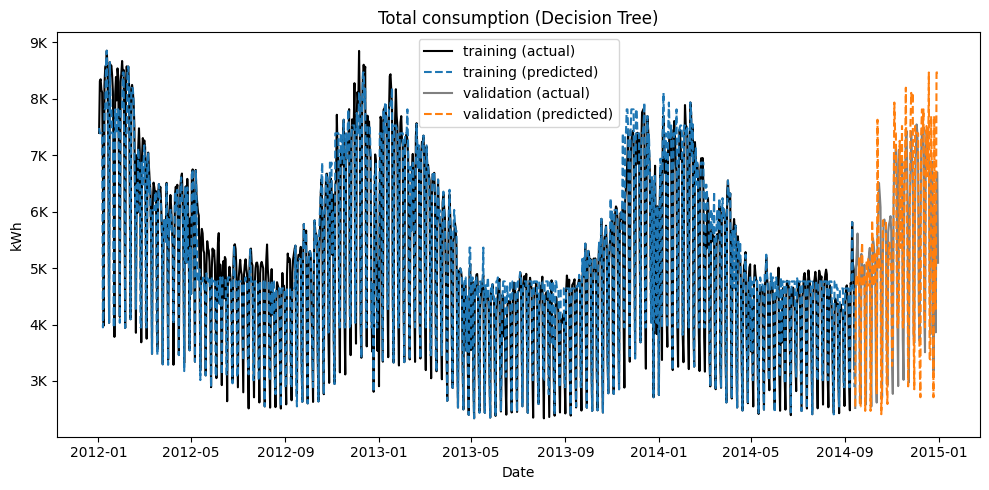

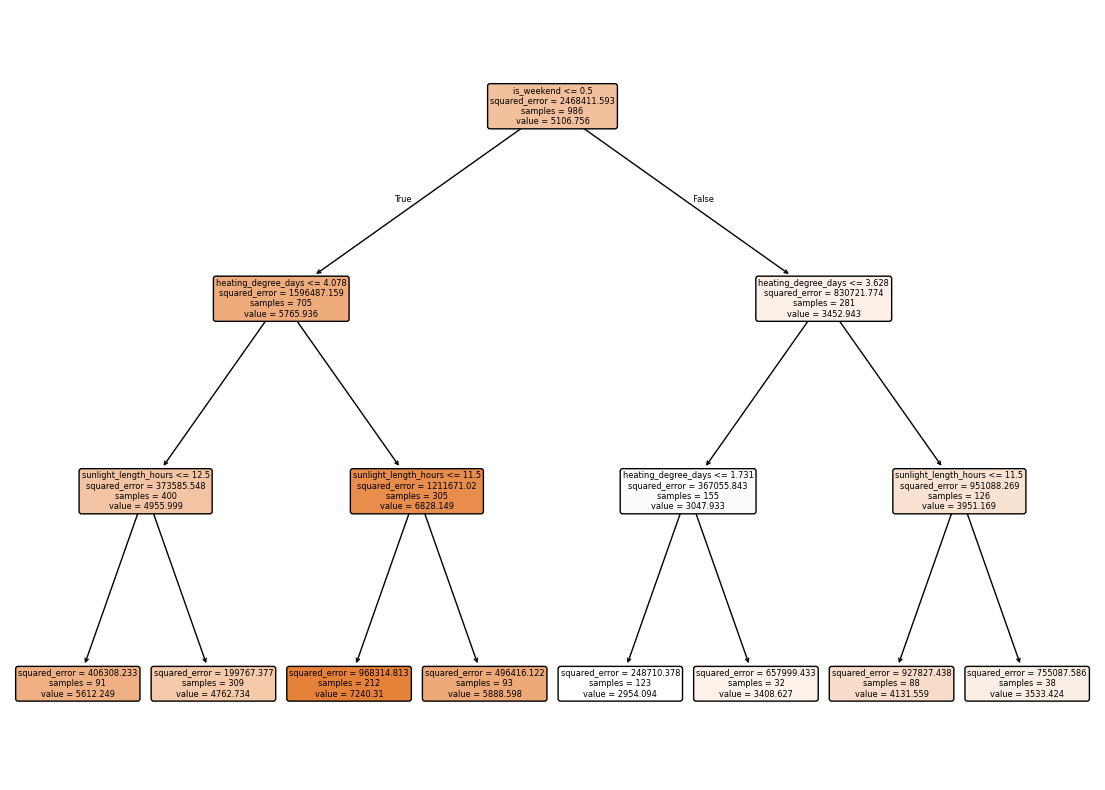

In [75]:
print('Cluster 4')
show_tree_regressor_results(X_4_train, y_4_train, X_4_val, y_4_val)

### OLS

In [76]:
def show_ols_results(X_train, y_train, X_val, y_val):
    ols_regressor = LinearRegression()
    ols_regressor.fit(X_train, y_train)

    # Print coefficients (feature importance for OLS)
    print("\nFeature Coefficients (Importance for OLS):")
    coef_df = pd.DataFrame({'Feature': common_features, 'Coefficient': ols_regressor.coef_})
    print(coef_df.to_string(index=False))

    y_train_pred = ols_regressor.predict(X_train)
    y_val_pred = ols_regressor.predict(X_val)

    # Evaluate the model
    mse = mean_squared_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    mape = mean_absolute_percentage_error(y_val, y_val_pred)
    print(f"\nMean Squared Error (MSE): {mse}")
    print(f"R-squared: {r2 * 100:.2f}%")
    print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

    # Statsmodels summary
    X_train_const = sm.add_constant(X_train)
    X_val_const = sm.add_constant(X_val)
    ols_model = sm.OLS(y_train, X_train_const).fit()
    print("\nOLS Model Summary:")
    print(ols_model.summary())

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

    ax.plot(pd.Series(y_train, index=train_dates), label='training (actual)', color='black', alpha=1)
    ax.plot(pd.Series(y_train_pred, index=train_dates), color='tab:blue', linestyle='--', label='training (predicted)')
    ax.plot(pd.Series(y_val, index=val_dates), label='validation (actual)', color='grey', alpha=1)
    ax.plot(pd.Series(y_val_pred, index=val_dates), color='tab:orange', linestyle='--', label='validation (predicted)')

    make_axes_human_readable(ax)
    ax.set_title('Total consumption (OLS)')
    ax.set_xlabel('Date')
    ax.set_ylabel('kWh')
    ax.legend()

    plt.tight_layout()
    plt.show()

Cluster 1

Feature Coefficients (Importance for OLS):
              Feature    Coefficient
  heating_degree_days -100460.809451
  cooling_degree_days  216434.625644
               precip   -5537.630363
           precipprob -116458.834578
           is_holiday  -84556.934772
sunlight_length_hours    -219.748075
           is_weekend   76549.687771

Mean Squared Error (MSE): 104912883539.05736
R-squared: 65.03%
Mean Absolute Percentage Error (MAPE): 6.47%

OLS Model Summary:
                                OLS Regression Results                                
Dep. Variable:     cluster1_electricity_usage   R-squared:                       0.835
Model:                                    OLS   Adj. R-squared:                  0.834
Method:                         Least Squares   F-statistic:                     706.0
Date:                        Thu, 13 Mar 2025   Prob (F-statistic):               0.00
Time:                                08:32:18   Log-Likelihood:                -13919.

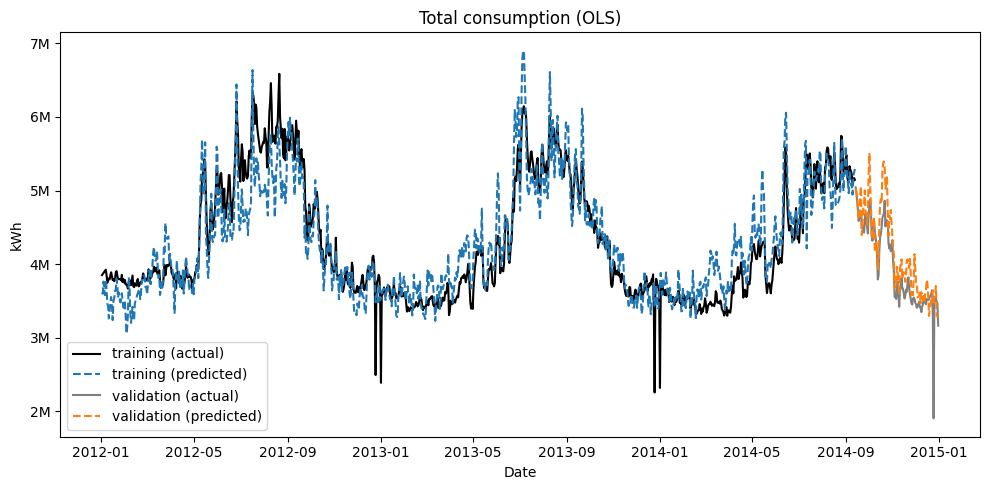

In [77]:
print('Cluster 1')
show_ols_results(X_1_train, y_1_train, X_1_val, y_1_val)

Cluster 2

Feature Coefficients (Importance for OLS):
              Feature  Coefficient
  heating_degree_days -1008.122852
  cooling_degree_days  6207.675174
               precip -3091.810564
           precipprob  -957.480073
           is_holiday -3698.125041
sunlight_length_hours   531.168640
           is_weekend  2420.976977

Mean Squared Error (MSE): 62454677.49178923
R-squared: 52.30%
Mean Absolute Percentage Error (MAPE): 4.75%

OLS Model Summary:
                                OLS Regression Results                                
Dep. Variable:     cluster2_electricity_usage   R-squared:                       0.707
Model:                                    OLS   Adj. R-squared:                  0.705
Method:                         Least Squares   F-statistic:                     337.9
Date:                        Thu, 13 Mar 2025   Prob (F-statistic):          5.87e-256
Time:                                08:32:19   Log-Likelihood:                -10513.
No. Observations

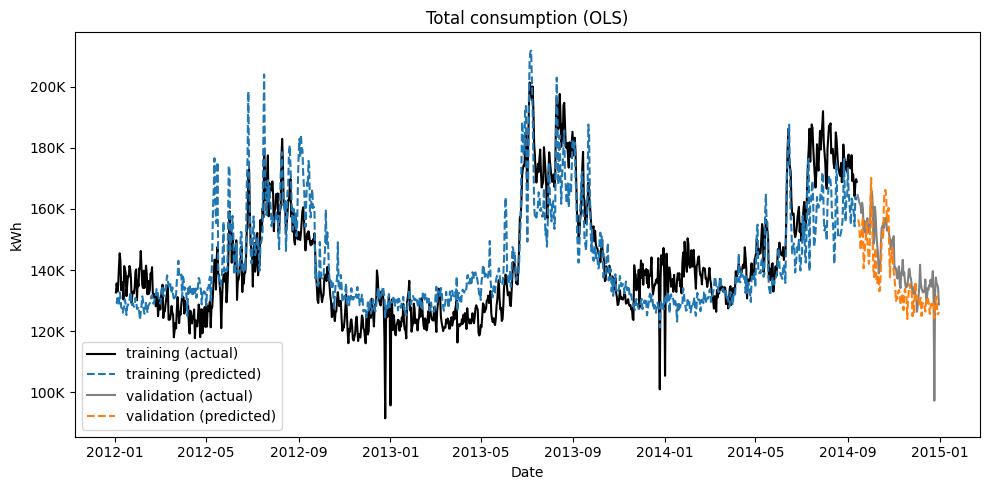

In [78]:
print('Cluster 2')
show_ols_results(X_2_train, y_2_train, X_2_val, y_2_val)

Cluster 3

Feature Coefficients (Importance for OLS):
              Feature  Coefficient
  heating_degree_days  3204.189212
  cooling_degree_days  4393.999436
               precip  -132.464432
           precipprob  2292.500609
           is_holiday -6320.564960
sunlight_length_hours -5201.139883
           is_weekend  -669.677877

Mean Squared Error (MSE): 98185982.4042725
R-squared: 70.86%
Mean Absolute Percentage Error (MAPE): 4.32%

OLS Model Summary:
                                OLS Regression Results                                
Dep. Variable:     cluster3_electricity_usage   R-squared:                       0.674
Model:                                    OLS   Adj. R-squared:                  0.672
Method:                         Least Squares   F-statistic:                     289.2
Date:                        Thu, 13 Mar 2025   Prob (F-statistic):          3.94e-233
Time:                                08:32:19   Log-Likelihood:                -10629.
No. Observations:

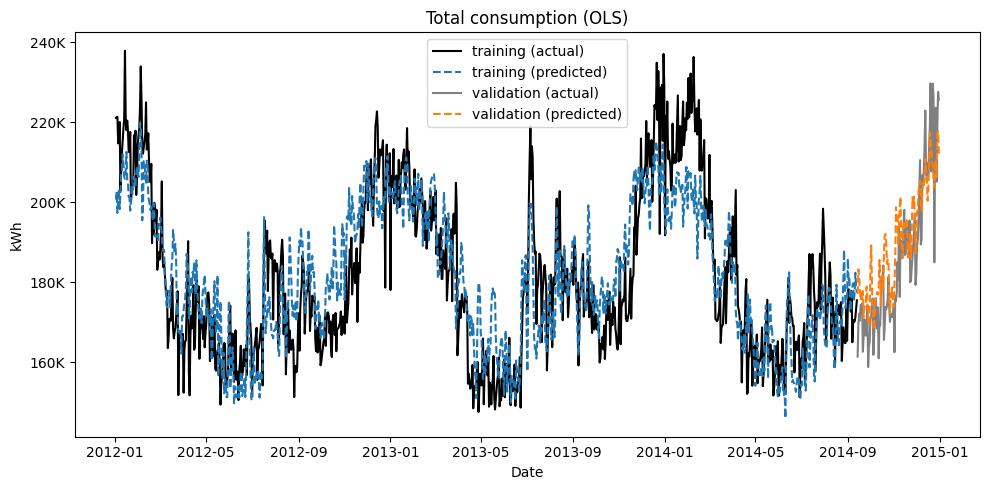

In [79]:
print('Cluster 3')
show_ols_results(X_3_train, y_3_train, X_3_val, y_3_val)

Cluster 4

Feature Coefficients (Importance for OLS):
              Feature  Coefficient
  heating_degree_days   164.961638
  cooling_degree_days    -2.086977
               precip   208.482687
           precipprob   -54.828681
           is_holiday -1245.701912
sunlight_length_hours  -199.276942
           is_weekend -2339.492409

Mean Squared Error (MSE): 436869.8007331719
R-squared: 80.23%
Mean Absolute Percentage Error (MAPE): 10.91%

OLS Model Summary:
                                OLS Regression Results                                
Dep. Variable:     cluster4_electricity_usage   R-squared:                       0.784
Model:                                    OLS   Adj. R-squared:                  0.783
Method:                         Least Squares   F-statistic:                     507.4
Date:                        Thu, 13 Mar 2025   Prob (F-statistic):          2.41e-320
Time:                                08:32:19   Log-Likelihood:                -7899.8
No. Observation

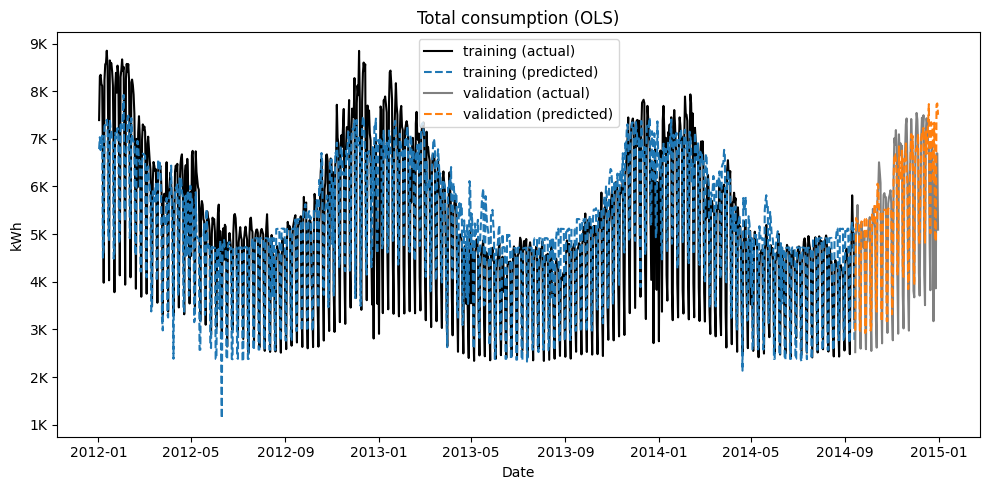

In [80]:
print('Cluster 4')
show_ols_results(X_4_train, y_4_train, X_4_val, y_4_val)

## Save good features

In [85]:
SAVE_PATH = 'dataset/combined_explanatory_variables/explanatory_variables.parquet'

filtered_explanatory_variables_df.to_parquet(SAVE_PATH)

pd.read_parquet(SAVE_PATH)

heating_degree_days  cooling_degree_days  precip  precipprob  \
date                                                                       
2012-01-01             6.578559                  0.0   0.000         0.0   
2012-01-02             6.659918                  0.0   0.111         1.0   
2012-01-03             7.977833                  0.0   0.000         0.0   
2012-01-04             6.335269                  0.0   0.000         0.0   
2012-01-05             7.437771                  0.0   0.000         0.0   
...                         ...                  ...     ...         ...   
2014-12-28             7.697900                  0.0   0.000         0.0   
2014-12-29            10.921202                  0.0   0.000         0.0   
2014-12-30            11.066679                  0.0   0.000         0.0   
2014-12-31            10.832410                  0.0   0.000         0.0   
2015-01-01             9.619572                  0.0   0.000         0.0   

            is_holiday  sunlight_length_hours  is_weekend  
date                                                       
2012-01-01           0                   10.0           1  
2012-01-02           0                   10.0           0  
2012-01-03           0                   10.0           0  
2012-01-04           0                   10.0           0  
2012-01-05           0                   10.0           0  
...                ...                    ...         ...  
2014-12-28           0                    9.0           1  
2014-12-29           0                    9.0           0  
2014-12-30           0                    9.0           0  
2014-12-31           0                   10.0           0  
2015-01-01           0                   10.0           0  

[1097 rows x 7 columns]

In [81]:
# def cluster_to_indicators(cluster_df: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
#     df_reset = cluster_df.T.reset_index()
#     df_long = pd.melt(df_reset, id_vars=['timestamp'], var_name='Customer', value_name='Consumption')
#     df_long = df_long.sort_values('timestamp')
    
#     df_long = pd.get_dummies(df_long, columns=['Customer'], prefix='Customer')
#     customer_columns = df_long.columns[df_long.columns.str.startswith('Customer')]
#     df_long[customer_columns] = df_long[customer_columns].astype(int)
#     df_long = df_long.set_index('timestamp')
#     df_long.index.name = 'date'
#     df_long = df_long.sort_index()
    
#     cluster_customer_indicators = df_long[customer_columns]
#     cluster_consumption = df_long['Consumption']

#     return cluster_customer_indicators, cluster_consumption

# cluster_1_customer_indicators, cluster_1_consumption = cluster_to_indicators(cluster_1_df)
# cluster_2_customer_indicators, cluster_1_consumption = cluster_to_indicators(cluster_2_df)
# cluster_3_customer_indicators, cluster_1_consumption = cluster_to_indicators(cluster_3_df)
# cluster_4_customer_indicators, cluster_1_consumption = cluster_to_indicators(cluster_4_df)